In [1]:
import json
import os
import warnings
from pathlib import Path
from typing import Any

import equinox as eqx
import jax.numpy as jnp
import jax.profiler
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from einops import rearrange, repeat
from ipywidgets import interact
from jax import config, device_count, random
from jax.scipy.optimize import minimize
from numpyencoder import NumpyEncoder
from scipy import constants
from stamox.sample import bootstrap

from jackpot.algorithms import AlgorithmChoice
from jackpot.algorithms.base import Algorithm
from jackpot.config import Config, JaxPlatform
from jackpot.fitting import SaturatingExponential
from jackpot.models.base import Model
from jackpot.models.ising import IsingModel
from jackpot.modules import AutocorrelationData
from jackpot.primitives.autocorrelate import acf
from jackpot.primitives.utils import beta_to_temp
from jackpot.profile import Stopwatch
from jackpot.state import Measurement, State
from jackpot.typing import RNGKey
from jackpot.utils.map import filter_map
from jackpot.utils.pbar import make_scan
from jackpot.utils.random import EasyKey

%load_ext autoreload
%autoreload 2

In [2]:
PAPERMILL: bool = False
PAPERMILL_INPUT_PATH: str = ""
PAPERMILL_OUTPUT_PATH: str = ""

In [3]:
# base
JAX_PLATFORM: JaxPlatform = JaxPlatform.CPU
DO_PROFILING: bool = False
ENABLE_64_BIT: bool = False
DO_AUTOCORRELATION: bool = False
DO_MEASURE: bool = True
PLOT_STATES: bool = False
CHECK_THERMALISED: bool = True

# experiment
RNG_SEED: int = 0
SPIN: float = 0.5
DIMENSIONS: int = 2
SIZE: int = 32
TOTAL_SAMPLES: int = 384
N_SAMPLES_VECTORISE: int = 2
LOOP_N_TEMPS_Y: bool = False


# environment
INTERACTION_BILINEAR: float = 1.0
INTERACTION_BIQUADRATIC: float = 0.0
INTERACTION_ANISOTROPY: float = 0.0
INTERACTION_BICUBIC: float = 0.0
INTERACTION_EXTERNAL_FIELD: float = 0.0
NUCLEAR_MAGNETIC_MOMENT: float = 1.0

# environment config
ALGORITHM: AlgorithmChoice = AlgorithmChoice.METROPOLIS_HASTINGS
PROBABILISTIC_CLUSTER_ACCEPT: bool = False

# temperatures
TEMP_MIN: float = 0.80
TEMP_MAX: float = 1.90
N_TEMPS: int = 96

# thermalisation
THERMALISE_STEPS: int = 50
THERMALISE_SWEEPS_PER_STEP: int = 50

# autocorrelation
AUTOCORRELATION_STEPS: int = 1000
AUTOCORRELATION_SWEEPS_PER_STEP: int = 2

# measure
MEASURE_EQUILIBRIUM_STEPS: int = 100
MEASURE_EQUILIBRIUM_NUM: int = 10
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP: int = 5

In [4]:
# Parameters
PAPERMILL_INPUT_PATH = "workbench.ipynb"
PAPERMILL_OUTPUT_PATH = "experiments/measure_3D/N40_wolff/experiment.ipynb"
PAPERMILL = True
RNG_SEED = 1
JAX_PLATFORM = "tpu"
ALGORITHM = "wolff"
DIMENSIONS = 3
SPIN = 0.5
TOTAL_SAMPLES = 256
N_TEMPS = 16
N_SAMPLES_VECTORISE = 16
THERMALISE_STEPS = 100
THERMALISE_SWEEPS_PER_STEP = 50
TEMP_MIN = 2.25
TEMP_MAX = 2.26
CHECK_THERMALISED = True
DO_AUTOCORRELATION = False
DO_MEASURE = True
MEASURE_EQUILIBRIUM_NUM = 1
MEASURE_EQUILIBRIUM_STEPS = 1000
MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP = 10
PLOT_STATES = False
SIZE = 40


In [5]:
if not PAPERMILL:
    RNG_SEED = 1
    JAX_PLATFORM = "tpu"
    ALGORITHM = "wolff"
    DIMENSIONS = 3
    SPIN = 0.5
    TOTAL_SAMPLES = 64
    N_TEMPS = 32
    N_SAMPLES_VECTORISE = 2
    THERMALISE_STEPS = 100
    THERMALISE_SWEEPS_PER_STEP = 50
    TEMP_MIN = 2.2
    TEMP_MAX = 2.4
    DO_AUTOCORRELATION = False
    DO_MEASURE = True
    SIZE = 32

In [6]:
# Post init
if PAPERMILL:
    from tqdm.std import tqdm
else:
    from tqdm.notebook import tqdm

if PAPERMILL_OUTPUT_PATH:
    SAVE_PATH = Path(PAPERMILL_OUTPUT_PATH).parent.resolve()
else:
    SAVE_PATH = (Path() / "experiments" / "last").resolve()
to_save: dict[str, Any] = {}

print(f"{SAVE_PATH=}")

_CONFIG_VARS = [
    "JAX_PLATFORM",
    "DO_PROFILING",
    "ENABLE_64_BIT",
    "DO_AUTOCORRELATION",
    "DO_MEASURE",
    "PLOT_STATES",
    "CHECK_THERMALISED",
    "RNG_SEED",
    "SPIN",
    "DIMENSIONS",
    "SIZE",
    "TOTAL_SAMPLES",
    "N_SAMPLES_VECTORISE",
    "LOOP_N_TEMPS_Y",
    "THERMALISE_STEPS",
    "THERMALISE_SWEEPS_PER_STEP",
    "INTERACTION_BILINEAR",
    "INTERACTION_BIQUADRATIC",
    "INTERACTION_ANISOTROPY",
    "INTERACTION_BICUBIC",
    "INTERACTION_EXTERNAL_FIELD",
    "NUCLEAR_MAGNETIC_MOMENT",
    "ALGORITHM",
    "PROBABILISTIC_CLUSTER_ACCEPT",
    "TEMP_MIN",
    "TEMP_MAX",
    "N_TEMPS",
    "AUTOCORRELATION_STEPS",
    "AUTOCORRELATION_SWEEPS_PER_STEP",
    "MEASURE_EQUILIBRIUM_STEPS",
    "MEASURE_EQUILIBRIUM_NUM",
    "MEASURE_EQUILIBRIUM_SWEEPS_PER_STEP",
]

_CONFIG_DICT = {}

for var in _CONFIG_VARS:
    _CONFIG_DICT[var.lower()] = globals()[var]
    del globals()[var]

c = Config(**_CONFIG_DICT)

with open(SAVE_PATH / "config.json", "w") as f:
    f.write(c.json(indent=4))


# ---
match c.jax_platform:
    case JaxPlatform.CPU:
        config.update("jax_platform_name", "cpu")
        config.update("jax_platforms", "cpu")

        # CPU cores as separate devices
        os.environ[
            "XLA_FLAGS"
        ] = f"--xla_force_host_platform_device_count={os.cpu_count()}"

    case JaxPlatform.TPU:
        config.update("jax_platform_name", "tpu")
        config.update("jax_platforms", "tpu")

        from jax.experimental.compilation_cache import compilation_cache

        compilation_cache.initialize_cache("/tmp/xla_comp_cache")

        # SEE: https://github.com/google/jax/discussions/12001#discussioncomment-3467948
        os.environ["LIBTPU_INIT_ARGS"] = "--xla_tpu_spmd_rng_bit_generator_unsafe=1"
        config.update("jax_default_prng_impl", "unsafe_rbg")

    case JaxPlatform.GPU:
        config.update("jax_platform_name", "gpu")
        config.update("jax_platforms", "gpu")

    case _:
        raise ValueError("Invalid JaxPlatform")

# config.update("jax_check_tracer_leaks", True)
if c.enable_64_bit:
    config.update("jax_enable_x64", True)

matplotlib.rcParams["figure.figsize"] = (10, 10)

if "_PROFILER_IS_RUNNING" not in globals() and c.do_profiling:
    _PROFILER_IS_RUNNING = True
    jax.profiler.start_server(9999)

Initialized persistent compilation cache at /tmp/xla_comp_cache


SAVE_PATH=PosixPath('/home/jeppe/JaxIsingModel/experiments/measure_3D/N40_wolff')


In [7]:
# Init

DEVICE_COUNT = device_count()
to_save["DEVICE_COUNT"] = DEVICE_COUNT
rng_seed = c.rng_seed if c.rng_seed is not None else np.random.randint(0, 10**10)
to_save["rng_seed"] = rng_seed
k = EasyKey(rng_seed)
rng_key = k.new

MODEL_BASE_PARAMS = {
    "interaction_bilinear": c.interaction_bilinear,
    "interaction_biquadratic": c.interaction_biquadratic,
    "interaction_anisotropy": c.interaction_anisotropy,
    "interaction_bicubic": c.interaction_bicubic,
    "interaction_external_field": c.interaction_external_field,
    "nuclear_magnetic_moment": c.nuclear_magnetic_moment,
    # "probabilistic_cluster_accept": c.probabilistic_cluster_accept,
}

if c.n_temps < DEVICE_COUNT:
    warnings.warn(
        f"Should have at least {DEVICE_COUNT} temperatures for maximum throughput"
    )
N_TEMPS_X = DEVICE_COUNT if DEVICE_COUNT < c.n_temps else c.n_temps
N_TEMPS_Y = c.n_temps // N_TEMPS_X
to_save["N_TEMPS_X"] = N_TEMPS_X
to_save["N_TEMPS_Y"] = N_TEMPS_Y

if not N_TEMPS_X * N_TEMPS_Y == c.n_temps:
    raise ValueError(f"Temperatures should be a multiple of {DEVICE_COUNT}")

N_SAMPLES_PER_TEMP = c.total_samples // (N_TEMPS_X * N_TEMPS_Y)
N_SAMPLES_LOOP = N_SAMPLES_PER_TEMP // c.n_samples_vectorise
to_save["N_SAMPLES_PER_TEMP"] = N_SAMPLES_PER_TEMP
to_save["N_SAMPLES_LOOP"] = N_SAMPLES_LOOP

VECTORISATION_SHAPE = (N_SAMPLES_LOOP, N_TEMPS_X, N_TEMPS_Y, c.n_samples_vectorise)

print(f"Temperatures: {c.n_temps:_}")
print(f"{c.n_temps=}")
print(f"{N_TEMPS_X=}")
print(f"{N_TEMPS_Y=}")
print(f"{N_SAMPLES_PER_TEMP=}")
print(f"--{c.n_samples_vectorise=}")
print(f"--{N_SAMPLES_LOOP=}")

if not N_SAMPLES_LOOP * c.n_samples_vectorise == N_SAMPLES_PER_TEMP:
    raise ValueError(
        "Failed to factorise in a good way. " f"Factors: {VECTORISATION_SHAPE}"
    )
to_save["VECTORISATION_SHAPE"] = VECTORISATION_SHAPE

VECTORISED_COUNT = np.prod(VECTORISATION_SHAPE)
to_save["VECTORISED_COUNT"] = VECTORISED_COUNT
print(f"Vectorised count: {VECTORISED_COUNT:_}")

if not VECTORISED_COUNT == c.total_samples:
    raise ValueError(
        f"Got bad vectorised count: {VECTORISED_COUNT=} != {c.total_samples=}"
    )

TOTAL_SWEEPS = VECTORISED_COUNT * c.thermalise_sweeps_per_step * c.thermalise_steps
to_save["TOTAL_SWEEPS"] = TOTAL_SWEEPS
print(f"Total sweeps: {TOTAL_SWEEPS:_}")

temperatures = np.linspace(c.temp_min, c.temp_max, c.n_temps)
betas = 1.0 / temperatures

match c.algorithm:
    case AlgorithmChoice.WOLFF | AlgorithmChoice.SWENDSEN_WANG:
        algorithm = c.algorithm.resolve()(
            probabilistic_cluster_accept=c.probabilistic_cluster_accept
        )
    case _:
        algorithm = c.algorithm.resolve()()


def transforms(in_axes, out_axes=0):
    def inner(fun):
        # SAMPLES_VECTORISE
        fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_Y
        if c.loop_n_temps_y:
            fun = filter_map(fun)
        else:
            fun = eqx.filter_vmap(fun, in_axes=in_axes, out_axes=out_axes)

        # TEMP_X
        fun = eqx.filter_pmap(fun, in_axes=in_axes, out_axes=out_axes)

        # SAMPLES_LOOP
        fun = filter_map(fun)

        fun = eqx.filter_jit(fun)

        return fun

    return inner


def calculate_known_total(steps: int) -> int:
    total = steps
    total *= N_SAMPLES_LOOP
    total *= N_TEMPS_X

    if c.loop_n_temps_y:
        total *= N_TEMPS_Y

    return total

Temperatures: 16
c.n_temps=16
N_TEMPS_X=8
N_TEMPS_Y=2
N_SAMPLES_PER_TEMP=16
--c.n_samples_vectorise=16
--N_SAMPLES_LOOP=1
Vectorised count: 256
Total sweeps: 1_280_000


In [8]:
# Single state
if not PAPERMILL:
    model = IsingModel.new(spin=c.spin, **MODEL_BASE_PARAMS)
    state = State.new_uniform_random(
        rng_key=k.new,
        dimensions=c.dimensions,
        size=c.size,
        beta=1.0,
        model=model,
        algorithm=algorithm,
        id_=0,
    )

    initial_state = state

    state = state.evolve_sweeps(rng_key=k.new, sweeps=1)
    measured = state.measure()

    state.calculate_energy()
    state.calculate_magnetisation_density()

# Thermalisation

In [9]:
@transforms(in_axes=(0, None, None, 0, 0, None, None, None, None, None))
def make_and_thermalise_states(
    rng_key: RNGKey,
    dimensions: int,
    size: int,
    beta: float,
    id_: int,
    steps: int,
    sweeps_per_step: int,
    model: Model,
    algorithm: Algorithm,
    num_prints: int = 10,
) -> tuple[State, Measurement]:
    """
    Constructs states and thermalises them, returning measurements along the
    way in addition to the thermalised states.

    Arguments:
        rng_key: Source of randomness,
        dimensions: Dimensionality of the system,
        size: Size of each lattice dimension,
        beta: The inverse temperature,
        id_: An ID of the state,
        steps: Number of steps in which to thermalise the state,
        sweeps_per_step: How many times to perform a algorithm sweep per
            thermalisation step,
        model: Instance of the model to use,
        algorithm: An instance of the algorithm to use,
        num_prints: Number of times to update the progress bar (approximately),
    """
    rng_key, state_key = random.split(key=rng_key, num=2)

    state = State.new_minimal(
        rng_key=state_key,
        dimensions=dimensions,
        size=size,
        beta=beta,
        model=model,
        algorithm=algorithm,
        id_=id_,
    )

    def evolve_and_measure(state: State, x: RNGKey) -> tuple[State, Measurement]:
        _key = x
        state = state.evolve_sweeps(rng_key=_key, sweeps=sweeps_per_step)
        measurement = state.measure()

        return state, measurement

    keys = random.split(rng_key, num=steps)
    scan = make_scan(
        tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
    )
    state, measurements = scan(f=evolve_and_measure, init=state, xs=keys)

    return state, measurements


_betas = rearrange(betas, "(x y) -> x y", x=N_TEMPS_X, y=N_TEMPS_Y)
_betas = repeat(
    _betas,
    "x y -> s_loop x y s_vec",
    s_vec=c.n_samples_vectorise,
    s_loop=N_SAMPLES_LOOP,
)
shape = _betas.shape
print(f"{shape=}")

ids = np.arange(np.prod(shape)).reshape(shape)

# Make state
model = IsingModel.new(
    spin=c.spin,
    **MODEL_BASE_PARAMS,
)

# rng_key: RNGKey
# spin: floatj
# dimensions: int
# size: int
# beta: float
# id_: int
# steps: int
# sweeps_per_step: int
# kwargs: dict[str, Any]
# num_prints: int = 10
state_keys = k.shaped(shape)
thermalise_num_prints = 10

thermalise_compile_timer = Stopwatch.start()
make_and_thermalise_states_compiled = make_and_thermalise_states.lower(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
).compile()
thermalise_compile_time = thermalise_compile_timer.time()
to_save["thermalise_compile_time"] = thermalise_compile_time
print(f"Compiled thermalisation program in: {thermalise_compile_time} sec.")

thermalise_run_timer = Stopwatch.start()
states, evolve_measurements = make_and_thermalise_states_compiled(
    state_keys,
    c.dimensions,
    c.size,
    _betas,
    ids,
    c.thermalise_steps,
    c.thermalise_sweeps_per_step,
    model,
    algorithm,
    thermalise_num_prints,
)
states.block_until_ready()
thermalise_run_time = thermalise_run_timer.time()
to_save["thermalise_run_time"] = thermalise_run_time
print(f"Ran thermalisation program in: {thermalise_run_time} sec.")

eqx.tree_serialise_leaves(SAVE_PATH / "states.eqx", states)

shape=(1, 8, 2, 16)


/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function make_and_thermalise_states includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


Compiled thermalisation program in: 9.353088617324829 sec.


  0%|                                                                                                                                    | 0/800 [00:00<?, ?it/s]

  2%|██▋                                                                                                                      | 18/800 [01:33<1:07:41,  5.19s/it]

  4%|████▎                                                                                                                      | 28/800 [01:34<37:53,  2.94s/it]

  5%|█████▊                                                                                                                     | 38/800 [01:35<23:16,  1.83s/it]

  7%|████████▉                                                                                                                  | 58/800 [01:35<10:47,  1.15it/s]

  8%|██████████▍                                                                                                                | 68/800 [01:35<07:53,  1.55it/s]

 10%|███████████▉                                                                                                               | 78/800 [01:36<05:52,  2.05it/s]

 11%|█████████████▌                                                                                                             | 88/800 [01:36<04:14,  2.80it/s]

 11%|█████████████▌                                                                                                             | 88/800 [01:50<04:14,  2.80it/s]

 12%|███████████████                                                                                                            | 98/800 [03:05<33:01,  2.82s/it]

 14%|████████████████▍                                                                                                         | 108/800 [03:09<24:27,  2.12s/it]

 16%|███████████████████▌                                                                                                      | 128/800 [03:10<13:02,  1.16s/it]

 17%|█████████████████████                                                                                                     | 138/800 [03:11<10:02,  1.10it/s]

 18%|██████████████████████▌                                                                                                   | 148/800 [03:12<07:34,  1.43it/s]

 20%|████████████████████████                                                                                                  | 158/800 [03:14<05:56,  1.80it/s]

 21%|█████████████████████████▌                                                                                                | 168/800 [03:14<04:26,  2.38it/s]

 21%|█████████████████████████▌                                                                                                | 168/800 [03:30<04:26,  2.38it/s]

 22%|███████████████████████████▏                                                                                              | 178/800 [04:39<28:13,  2.72s/it]

 24%|████████████████████████████▋                                                                                             | 188/800 [04:45<21:27,  2.10s/it]

 25%|██████████████████████████████▏                                                                                           | 198/800 [04:45<14:59,  1.49s/it]

 26%|███████████████████████████████▋                                                                                          | 208/800 [04:47<10:53,  1.10s/it]

 27%|█████████████████████████████████▏                                                                                        | 218/800 [04:47<07:36,  1.28it/s]

 28%|██████████████████████████████████▊                                                                                       | 228/800 [04:48<05:21,  1.78it/s]

 30%|████████████████████████████████████▎                                                                                     | 238/800 [04:51<04:28,  2.09it/s]

 31%|█████████████████████████████████████▊                                                                                    | 248/800 [04:52<03:22,  2.72it/s]

 31%|█████████████████████████████████████▊                                                                                    | 248/800 [05:10<03:22,  2.72it/s]

 32%|███████████████████████████████████████▎                                                                                  | 258/800 [06:12<24:00,  2.66s/it]

 34%|████████████████████████████████████████▊                                                                                 | 268/800 [06:20<18:43,  2.11s/it]

 35%|██████████████████████████████████████████▍                                                                               | 278/800 [06:21<13:04,  1.50s/it]

 36%|███████████████████████████████████████████▉                                                                              | 288/800 [06:22<09:12,  1.08s/it]

 37%|█████████████████████████████████████████████▍                                                                            | 298/800 [06:23<06:36,  1.26it/s]

 38%|██████████████████████████████████████████████▉                                                                           | 308/800 [06:24<04:49,  1.70it/s]

 40%|████████████████████████████████████████████████▍                                                                         | 318/800 [06:27<04:05,  1.96it/s]

 41%|██████████████████████████████████████████████████                                                                        | 328/800 [06:29<03:10,  2.48it/s]

 42%|███████████████████████████████████████████████████▌                                                                      | 338/800 [07:45<19:50,  2.58s/it]

 44%|█████████████████████████████████████████████████████                                                                     | 348/800 [07:55<15:44,  2.09s/it]

 45%|██████████████████████████████████████████████████████▌                                                                   | 358/800 [07:57<11:15,  1.53s/it]

 46%|████████████████████████████████████████████████████████                                                                  | 368/800 [07:57<07:45,  1.08s/it]

 47%|█████████████████████████████████████████████████████████▋                                                                | 378/800 [07:59<05:43,  1.23it/s]

 48%|███████████████████████████████████████████████████████████▏                                                              | 388/800 [08:01<04:14,  1.62it/s]

 50%|████████████████████████████████████████████████████████████▋                                                             | 398/800 [08:04<03:28,  1.93it/s]

 51%|██████████████████████████████████████████████████████████████▏                                                           | 408/800 [08:06<02:51,  2.28it/s]

 52%|███████████████████████████████████████████████████████████████▋                                                          | 418/800 [09:19<15:43,  2.47s/it]

 54%|█████████████████████████████████████████████████████████████████▎                                                        | 428/800 [09:29<12:35,  2.03s/it]

 55%|██████████████████████████████████████████████████████████████████▊                                                       | 438/800 [09:34<09:31,  1.58s/it]

 56%|████████████████████████████████████████████████████████████████████▎                                                     | 448/800 [09:34<06:32,  1.12s/it]

 57%|█████████████████████████████████████████████████████████████████████▊                                                    | 458/800 [09:36<04:49,  1.18it/s]

 58%|███████████████████████████████████████████████████████████████████████▎                                                  | 468/800 [09:37<03:22,  1.64it/s]

 60%|████████████████████████████████████████████████████████████████████████▉                                                 | 478/800 [09:41<02:58,  1.81it/s]

 61%|██████████████████████████████████████████████████████████████████████████▍                                               | 488/800 [09:42<02:11,  2.37it/s]

 62%|███████████████████████████████████████████████████████████████████████████▉                                              | 498/800 [10:51<11:51,  2.36s/it]

 64%|█████████████████████████████████████████████████████████████████████████████▍                                            | 508/800 [11:06<10:09,  2.09s/it]

 65%|██████████████████████████████████████████████████████████████████████████████▉                                           | 518/800 [11:09<07:20,  1.56s/it]

 66%|████████████████████████████████████████████████████████████████████████████████▌                                         | 528/800 [11:09<05:01,  1.11s/it]

 67%|██████████████████████████████████████████████████████████████████████████████████                                        | 538/800 [11:13<03:51,  1.13it/s]

 68%|███████████████████████████████████████████████████████████████████████████████████▌                                      | 548/800 [11:13<02:37,  1.60it/s]

 70%|█████████████████████████████████████████████████████████████████████████████████████                                     | 558/800 [11:19<02:29,  1.62it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▌                                   | 568/800 [11:20<01:43,  2.23it/s]

 71%|██████████████████████████████████████████████████████████████████████████████████████▌                                   | 568/800 [11:40<01:43,  2.23it/s]

 72%|████████████████████████████████████████████████████████████████████████████████████████▏                                 | 578/800 [12:25<08:26,  2.28s/it]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▋                                | 588/800 [12:39<07:02,  1.99s/it]

 75%|███████████████████████████████████████████████████████████████████████████████████████████▏                              | 598/800 [12:44<05:15,  1.56s/it]

 76%|████████████████████████████████████████████████████████████████████████████████████████████▋                             | 608/800 [12:45<03:33,  1.11s/it]

 77%|██████████████████████████████████████████████████████████████████████████████████████████████▏                           | 618/800 [12:50<02:48,  1.08it/s]

 78%|███████████████████████████████████████████████████████████████████████████████████████████████▊                          | 628/800 [12:50<01:53,  1.51it/s]

 80%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                        | 638/800 [12:57<01:47,  1.50it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 648/800 [12:58<01:14,  2.04it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 648/800 [13:10<01:14,  2.04it/s]

 82%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 658/800 [13:58<05:06,  2.16s/it]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 667/800 [14:08<04:09,  1.87s/it]

 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 677/800 [14:13<02:56,  1.43s/it]

 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 687/800 [14:19<02:15,  1.20s/it]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 696/800 [14:22<01:38,  1.06it/s]

 88%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 706/800 [14:22<01:01,  1.52it/s]

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 716/800 [14:27<00:49,  1.68it/s]

 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 735/800 [14:29<00:24,  2.63it/s]

 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 744/800 [14:32<00:20,  2.79it/s]

 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 754/800 [14:33<00:14,  3.24it/s]

 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 763/800 [14:36<00:11,  3.15it/s]

 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎  | 782/800 [14:37<00:03,  5.41it/s]

 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 791/800 [14:43<00:02,  3.21it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [14:47<00:00,  3.11it/s]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 800/800 [15:00<00:00,  3.11it/s]

Ran thermalisation program in: 975.1775102615356 sec.


In [10]:
_evolve_meas_df = evolve_measurements.to_df()
evolve_meas_df = _evolve_meas_df.explode(
    _evolve_meas_df.columns.tolist()
).infer_objects()

evolve_meas_df["temp"] = beta_to_temp(evolve_meas_df["beta"], human=True)
evolve_meas_df["abs_magnetisation_density"] = np.abs(
    evolve_meas_df["magnetisation_density"]
)

In [11]:
# Get only last measurements
last_meas_df = (
    evolve_meas_df.sort_values("sweeps", ascending=False).groupby("state_id").first()
)
n_steps = last_meas_df["steps"].sum()

flip_rate = n_steps / (thermalise_run_time * 1e6)  # flips / μs
to_save["flip_rate"] = flip_rate
print(f"Flip rate: {flip_rate} flips/μs")

Flip rate: 3.3052994178829516 flips/μs


In [12]:
evolve_meas_df.reset_index().to_feather(SAVE_PATH / "evolve_meas_df.feather")

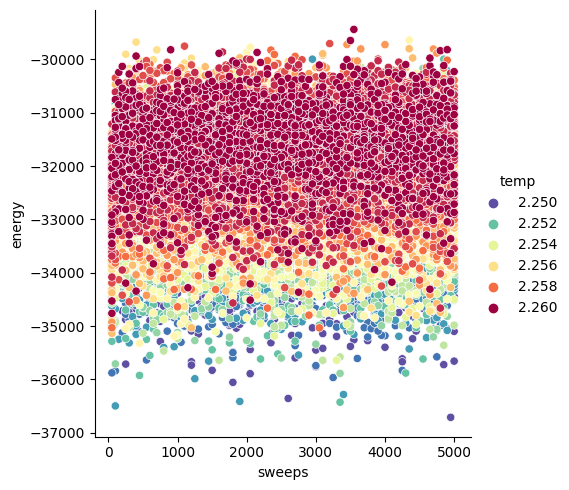

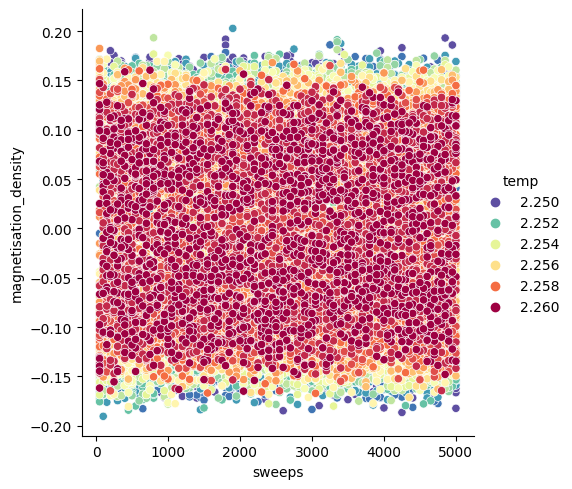

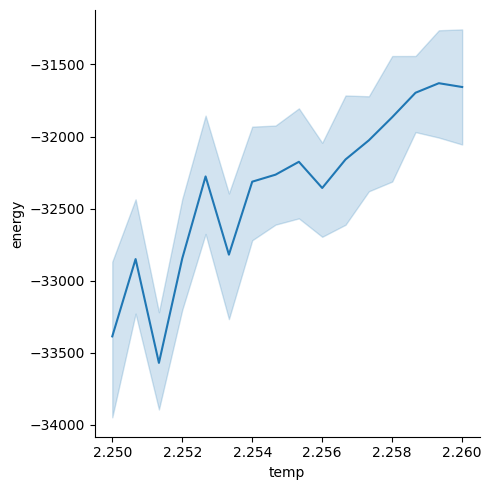

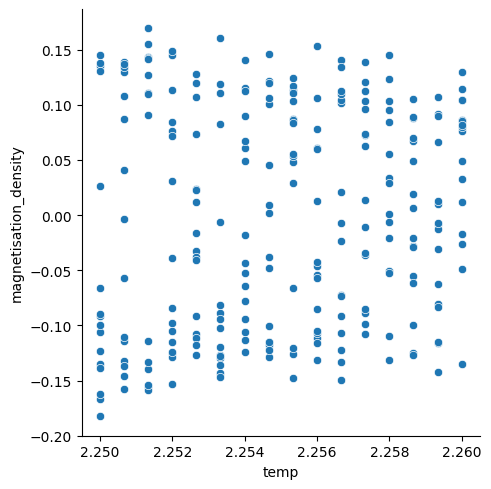

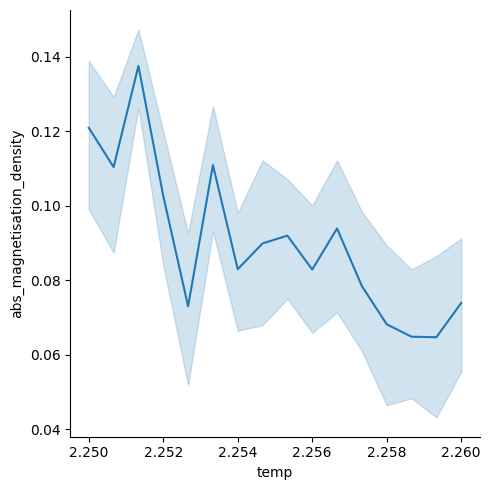

In [13]:
fig_evolve_energy_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="energy",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_energy_sweeps.savefig(SAVE_PATH / "fig_evolve_energy_sweeps.png")

fig_evolve_mag_dens_sweeps = sns.relplot(
    data=evolve_meas_df,
    x="sweeps",
    y="magnetisation_density",
    hue="temp",
    palette="Spectral_r",
)
fig_evolve_mag_dens_sweeps.savefig(SAVE_PATH / "fig_evolve_mag_dens_sweeps.png")

last_sweeps = evolve_meas_df[
    evolve_meas_df["sweeps"] == np.max(evolve_meas_df["sweeps"])
]

fig_evolve_energy_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="energy",
    # hue="beta",
    kind="line",
    # errorbar=None
)
fig_evolve_energy_temp.savefig(SAVE_PATH / "fig_evolve_energy_temp.png")

fig_evolve_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="magnetisation_density",
)
fig_evolve_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_mag_dens_temp.png")

fig_evolve_abs_mag_dens_temp = sns.relplot(
    data=last_sweeps,
    x="temp",
    y="abs_magnetisation_density",
    kind="line",
    # errorbar=None
)
fig_evolve_abs_mag_dens_temp.savefig(SAVE_PATH / "fig_evolve_abs_mag_dens_temp.png")

In [14]:
if c.plot_states:
    states_list = states.unensamble()
    temp_states = states_list[: c.n_temps]

In [15]:
if c.plot_states:

    @interact(value=0, min=0, max=len(temp_states))
    def update(i=(0, len(temp_states) - 1)):
        fig = temp_states[i].plot()
        fig.set_size_inches(10, 10)
        fig.dpi = 100

    ...

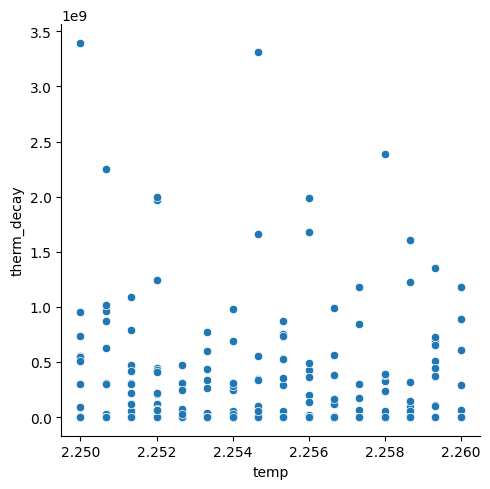

In [16]:
if c.check_thermalised:
    # Fit saturating decay times to quantifiably understand whether we have fully thermalised
    def fit_thermalisation(group):
        x = group["sweeps"]
        y = group["energy"]

        amplitude = np.max(y) - np.min(y)
        decay = np.max(x)
        offset = y.iloc[-1]

        params = SaturatingExponential.make_params()
        params["amplitude"].set(amplitude)
        params["decay"].set(decay, min=0, max=np.inf)
        params["c"].set(offset)

        fit = SaturatingExponential.fit(y, params, x=x)

        assert np.ptp(group["temp"]) == 0.0

        return pd.Series(
            {
                "temp": group["temp"].iloc[0],
                "therm_amplitude": fit.params["amplitude"].value,
                "therm_amplitude_sd": fit.params["amplitude"].stderr,
                "therm_decay": fit.params["decay"].value,
                "therm_decay_sd": fit.params["decay"].stderr,
                "therm_offset": fit.params["c"].value,
                "therm_offset_sd": fit.params["c"].stderr,
            }
        )

    evolve_meas_fit_df = evolve_meas_df.groupby("state_id", as_index=False).apply(
        fit_thermalisation
    )
    fig_evolve_therm_fit = sns.relplot(
        data=evolve_meas_fit_df,
        x="temp",
        y="therm_decay",
    )
    fig_evolve_therm_fit.savefig(SAVE_PATH / "fig_evolve_therm_fit.png")

    def _has_thermalised():
        high_temp_df = evolve_meas_fit_df[
            evolve_meas_fit_df["temp"] == evolve_meas_fit_df["temp"].max()
        ]
        therm_check_df = high_temp_df[
            high_temp_df["therm_decay"] > 4.0 * high_temp_df["therm_decay_sd"]
        ]

        # We have no data to check probably because system is very very thermalised
        # and thus has no data to fit to exponential
        if not len(therm_check_df):
            return True

        longest_decay = therm_check_df["therm_decay"].max()
        print(longest_decay)
        if evolve_meas_df["sweeps"].max() > 6.0 * longest_decay:
            return True

        return False

    has_thermalised = _has_thermalised()

    if not has_thermalised:
        raise RuntimeError("System has not fully thermalised!")

# Autocorrelation

In [17]:
if c.do_autocorrelation:

    @transforms(in_axes=(0, 0, None, None, None), out_axes=0)
    def get_autocorrelation(
        key: RNGKey, state: State, steps: int, sweeps_per_step: int, num_prints: int
    ) -> AutocorrelationData:
        keys = random.split(key, num=steps)

        def get_measurement_scan(state: State, x: RNGKey) -> tuple[State, Measurement]:
            rng_key = x
            state = state.evolve_sweeps(rng_key=rng_key, sweeps=sweeps_per_step)
            measurement = state.measure()

            return state, measurement

        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=get_measurement_scan, init=state, xs=keys)

        acorr_energy = acf(measurements.energy)
        acorr_mag_dens = acf(jnp.abs(measurements.magnetisation_density))

        sweeps = jnp.arange(acorr_energy.size) * sweeps_per_step

        # Fit exponential decay to find characteristic autocorrelation time
        def exponential_decay(x, tau):
            """
            f(x) = exp(- x / τ)
            """
            return jnp.exp(-x / tau)

        # Objective function to minimise
        def objective(params, x, y, weights):
            tau = params
            trial = exponential_decay(x, tau)
            residuals = y - trial
            weighted_residuals = weights * residuals

            return jnp.sum(weighted_residuals**2)

        energy_initial_params = jnp.asarray([float(sweeps_per_step)])
        # Noise at high x (low y) dominates fit.
        # Weigh by ordinate magnitude
        energy_weights = jnp.abs(acorr_energy)
        energy_decay_time = minimize(
            objective,
            x0=energy_initial_params,
            method="BFGS",
            args=(sweeps, acorr_energy, energy_weights),
        ).x[0]

        mag_dens_initial_params = jnp.asarray([float(sweeps_per_step)])
        mag_dens_weights = jnp.abs(acorr_mag_dens)
        mag_dens_decay_time = minimize(
            objective,
            x0=mag_dens_initial_params,
            method="BFGS",
            args=(sweeps, acorr_mag_dens, mag_dens_weights),
        ).x[0]

        return AutocorrelationData(
            state=state,
            steps=steps,
            sweeps_per_step=sweeps_per_step,
            sweeps=sweeps,
            energy=acorr_energy,
            magnetisation_density=acorr_mag_dens,
            energy_decay_time=energy_decay_time,
            magnetisation_density_decay_time=mag_dens_decay_time,
        )

    keys = k.shaped(states.transformation_shape)

    autocorrelation_timer = Stopwatch.start()
    ac_data = get_autocorrelation(
        keys, states, c.autocorrelation_steps, c.autocorrelation_sweeps_per_step, 10
    )
    ac_data.block_until_ready()

    autocorrelation_time = autocorrelation_timer.time()
    to_save["autocorrelation_time"] = autocorrelation_time
    print(f"Ran autocorrelation program in: {autocorrelation_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "ac_data.eqx", ac_data)

In [18]:
if c.do_autocorrelation:
    ac_df = ac_data.to_df()
    ac_df["temp"] = beta_to_temp(ac_df["state.beta"], human=True)
    ac_df_expl = ac_df.explode(
        ["energy", "magnetisation_density", "sweeps"]
    ).infer_objects()

    ac_df_expl["energy_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["energy_decay_time"]
    )
    ac_df_expl["mag_dens_fit"] = np.exp(
        -ac_df_expl["sweeps"] / ac_df_expl["magnetisation_density_decay_time"]
    )

    display(ac_df)
    display(ac_df_expl)

    ac_df.reset_index().to_feather(SAVE_PATH / "ac_df.feather")
    ac_df_expl.reset_index().to_feather(SAVE_PATH / "ac_df_expl.feather")

In [19]:
if c.do_autocorrelation:
    fig_autocorrelation_energy = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="energy_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_energy.savefig(SAVE_PATH / "fig_autocorrelation_energy.png")

    fig_autocorrelation_mag_dens = plt.figure()
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="magnetisation_density",
        hue="temp",
        palette="Spectral_r",
        errorbar=None,
    )
    sns.lineplot(
        data=ac_df_expl,
        x="sweeps",
        y="mag_dens_fit",
        hue="temp",
        palette="Spectral_r",
        ls="--",
        errorbar=None,
    )
    fig_autocorrelation_mag_dens.savefig(SAVE_PATH / "fig_autocorrelation_mag_dens.png")

    fig_autocorrelation_decay_times, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    sns.lineplot(
        data=ac_df,
        x="temp",
        y="energy_decay_time",
        ax=ax1,
    )
    sns.lineplot(
        data=ac_df,
        x="temp",
        y="magnetisation_density_decay_time",
        ax=ax2,
        color="orange",
    )
    plt.show()
    fig_autocorrelation_decay_times.savefig(
        SAVE_PATH / "fig_autocorrelation_decay_times.png"
    )

# Measure Equilibrium

In [20]:
if c.do_measure:

    @transforms(in_axes=(0, 0, None, None, None, None), out_axes=0)
    def measure_equilibrium(
        key: RNGKey, state: State, steps: int, num: int, sweeps: int, num_prints: int
    ) -> Measurement:
        def body_fun(carry: State, x: RNGKey):
            _rng_key = x
            measurements = carry.evolve_and_measure_multiple(
                rng_key=_rng_key, num=num, sweeps=sweeps
            )

            return carry, measurements

        keys = random.split(key=key, num=steps)
        scan = make_scan(
            tqdm=tqdm, num_prints=num_prints, known_total=calculate_known_total(steps)
        )
        state, measurements = scan(f=body_fun, init=state, xs=keys)

        return measurements

    keys = k.shaped(states.transformation_shape)

    measurement_timer = Stopwatch.start()
    equil_measurements = measure_equilibrium(
        keys,
        states,
        c.measure_equilibrium_steps,
        c.measure_equilibrium_num,
        c.measure_equilibrium_sweeps_per_step,
        100,
    )
    equil_measurements.block_until_ready()

    measurement_time = measurement_timer.time()
    to_save["measurement_time"] = measurement_time
    print(f"Ran measurement program in: {measurement_time} sec.")

    eqx.tree_serialise_leaves(SAVE_PATH / "equil_measurements.eqx", equil_measurements)

/home/jeppe/JaxIsingModel/.venv/lib/python3.11/site-packages/jax/_src/dispatch.py:289: UserWarning: The jitted function measure_equilibrium includes a pmap. Using jit-of-pmap can lead to inefficient data movement, as the outer jit does not preserve sharded data representations and instead collects input and output arrays onto a single device. Consider removing the outer jit unless you know what you're doing. See https://github.com/google/jax/issues/2926.
  warnings.warn(


  0%|                                                                                                                                   | 0/8000 [00:00<?, ?it/s]

  0%|▎                                                                                                                       | 18/8000 [00:18<2:19:53,  1.05s/it]

  0%|▌                                                                                                                         | 38/8000 [00:19<54:32,  2.43it/s]

  1%|▉                                                                                                                         | 58/8000 [00:19<30:26,  4.35it/s]

  1%|█                                                                                                                         | 68/8000 [00:19<23:39,  5.59it/s]

  1%|█▏                                                                                                                        | 78/8000 [00:19<17:49,  7.41it/s]

  1%|█▎                                                                                                                        | 88/8000 [00:20<14:44,  8.95it/s]

  1%|█▎                                                                                                                        | 88/8000 [00:33<14:44,  8.95it/s]

  1%|█▍                                                                                                                      | 98/8000 [00:37<1:15:20,  1.75it/s]

  1%|█▊                                                                                                                       | 118/8000 [00:38<42:55,  3.06it/s]

  2%|█▉                                                                                                                       | 128/8000 [00:38<34:10,  3.84it/s]

  2%|██                                                                                                                       | 138/8000 [00:39<26:47,  4.89it/s]

  2%|██▏                                                                                                                      | 148/8000 [00:39<21:06,  6.20it/s]

  2%|██▌                                                                                                                      | 168/8000 [00:39<12:29, 10.45it/s]

  2%|██▌                                                                                                                      | 168/8000 [00:53<12:29, 10.45it/s]

  2%|██▋                                                                                                                    | 178/8000 [00:56<1:02:08,  2.10it/s]

  2%|██▉                                                                                                                      | 198/8000 [00:57<37:42,  3.45it/s]

  3%|███▏                                                                                                                     | 208/8000 [00:58<31:52,  4.07it/s]

  3%|███▎                                                                                                                     | 218/8000 [00:59<27:11,  4.77it/s]

  3%|███▍                                                                                                                     | 228/8000 [00:59<20:34,  6.29it/s]

  3%|███▊                                                                                                                     | 248/8000 [00:59<12:31, 10.32it/s]

  3%|███▊                                                                                                                     | 248/8000 [01:13<12:31, 10.32it/s]

  3%|███▉                                                                                                                     | 258/8000 [01:16<59:05,  2.18it/s]

  3%|████                                                                                                                     | 268/8000 [01:16<44:44,  2.88it/s]

  3%|████▏                                                                                                                    | 278/8000 [01:16<34:41,  3.71it/s]

  4%|████▎                                                                                                                    | 288/8000 [01:17<27:46,  4.63it/s]

  4%|████▌                                                                                                                    | 298/8000 [01:18<24:13,  5.30it/s]

  4%|████▋                                                                                                                    | 308/8000 [01:18<18:12,  7.04it/s]

  4%|████▊                                                                                                                    | 318/8000 [01:19<14:29,  8.83it/s]

  4%|████▉                                                                                                                    | 328/8000 [01:19<10:51, 11.78it/s]

  4%|████▉                                                                                                                    | 328/8000 [01:33<10:51, 11.78it/s]

  4%|█████                                                                                                                  | 338/8000 [01:34<1:04:47,  1.97it/s]

  4%|█████▎                                                                                                                   | 348/8000 [01:35<48:51,  2.61it/s]

  4%|█████▍                                                                                                                   | 358/8000 [01:35<35:38,  3.57it/s]

  5%|█████▌                                                                                                                   | 368/8000 [01:36<25:52,  4.92it/s]

  5%|█████▋                                                                                                                   | 378/8000 [01:37<24:39,  5.15it/s]

  5%|█████▊                                                                                                                   | 388/8000 [01:38<18:02,  7.03it/s]

  5%|██████▏                                                                                                                  | 408/8000 [01:38<12:01, 10.52it/s]

  5%|██████▏                                                                                                                  | 408/8000 [01:53<12:01, 10.52it/s]

  5%|██████▎                                                                                                                  | 418/8000 [01:53<55:13,  2.29it/s]

  5%|██████▍                                                                                                                  | 428/8000 [01:54<42:29,  2.97it/s]

  5%|██████▌                                                                                                                  | 438/8000 [01:54<33:22,  3.78it/s]

  6%|██████▊                                                                                                                  | 448/8000 [01:55<25:00,  5.03it/s]

  6%|██████▉                                                                                                                  | 458/8000 [01:57<26:42,  4.71it/s]

  6%|███████▏                                                                                                                 | 478/8000 [01:58<16:50,  7.44it/s]

  6%|███████▌                                                                                                                 | 498/8000 [02:12<44:40,  2.80it/s]

  6%|███████▋                                                                                                                 | 508/8000 [02:12<35:36,  3.51it/s]

  6%|███████▊                                                                                                                 | 518/8000 [02:13<30:48,  4.05it/s]

  7%|███████▉                                                                                                                 | 528/8000 [02:14<23:59,  5.19it/s]

  7%|████████▏                                                                                                                | 538/8000 [02:16<25:07,  4.95it/s]

  7%|████████▎                                                                                                                | 548/8000 [02:17<21:13,  5.85it/s]

  7%|████████▍                                                                                                                | 558/8000 [02:17<16:21,  7.58it/s]

  7%|████████▌                                                                                                                | 568/8000 [02:18<14:20,  8.64it/s]

  7%|████████▋                                                                                                                | 578/8000 [02:31<56:01,  2.21it/s]

  7%|████████▉                                                                                                                | 588/8000 [02:31<41:44,  2.96it/s]

  7%|█████████                                                                                                                | 598/8000 [02:33<34:11,  3.61it/s]

  8%|█████████▎                                                                                                               | 618/8000 [02:35<24:48,  4.96it/s]

  8%|█████████▍                                                                                                               | 628/8000 [02:36<22:52,  5.37it/s]

  8%|█████████▋                                                                                                               | 638/8000 [02:37<18:45,  6.54it/s]

  8%|█████████▊                                                                                                               | 648/8000 [02:38<16:27,  7.45it/s]

  8%|█████████▉                                                                                                               | 658/8000 [02:50<54:00,  2.27it/s]

  8%|██████████                                                                                                               | 668/8000 [02:50<39:00,  3.13it/s]

  8%|██████████▎                                                                                                              | 678/8000 [02:52<33:17,  3.67it/s]

  9%|██████████▍                                                                                                              | 688/8000 [02:52<24:06,  5.05it/s]

  9%|██████████▌                                                                                                              | 698/8000 [02:54<25:10,  4.84it/s]

  9%|██████████▋                                                                                                              | 708/8000 [02:56<24:53,  4.88it/s]

  9%|██████████▊                                                                                                              | 718/8000 [02:56<17:59,  6.75it/s]

  9%|███████████                                                                                                              | 728/8000 [02:58<16:26,  7.37it/s]

  9%|███████████▏                                                                                                             | 738/8000 [03:09<53:23,  2.27it/s]

  9%|███████████▎                                                                                                             | 748/8000 [03:10<39:06,  3.09it/s]

  9%|███████████▍                                                                                                             | 758/8000 [03:11<31:43,  3.80it/s]

 10%|███████████▌                                                                                                             | 768/8000 [03:11<23:16,  5.18it/s]

 10%|███████████▊                                                                                                             | 778/8000 [03:14<26:14,  4.59it/s]

 10%|███████████▉                                                                                                             | 788/8000 [03:16<24:45,  4.86it/s]

 10%|████████████                                                                                                             | 798/8000 [03:16<19:49,  6.05it/s]

 10%|████████████▏                                                                                                            | 808/8000 [03:18<18:53,  6.34it/s]

 10%|████████████▎                                                                                                            | 818/8000 [03:28<50:48,  2.36it/s]

 10%|████████████▌                                                                                                            | 828/8000 [03:29<37:17,  3.20it/s]

 10%|████████████▋                                                                                                            | 838/8000 [03:30<30:38,  3.90it/s]

 11%|████████████▊                                                                                                            | 848/8000 [03:30<23:16,  5.12it/s]

 11%|████████████▉                                                                                                            | 858/8000 [03:33<26:43,  4.45it/s]

 11%|█████████████▏                                                                                                           | 868/8000 [03:36<27:23,  4.34it/s]

 11%|█████████████▍                                                                                                           | 888/8000 [03:38<21:17,  5.57it/s]

 11%|█████████████▌                                                                                                           | 898/8000 [03:47<42:32,  2.78it/s]

 11%|█████████████▋                                                                                                           | 908/8000 [03:48<34:07,  3.46it/s]

 11%|█████████████▉                                                                                                           | 918/8000 [03:49<27:53,  4.23it/s]

 12%|██████████████                                                                                                           | 928/8000 [03:50<23:40,  4.98it/s]

 12%|██████████████▏                                                                                                          | 938/8000 [03:53<26:59,  4.36it/s]

 12%|██████████████▎                                                                                                          | 948/8000 [03:55<25:35,  4.59it/s]

 12%|██████████████▍                                                                                                          | 958/8000 [03:56<19:46,  5.94it/s]

 12%|██████████████▋                                                                                                          | 968/8000 [03:58<21:39,  5.41it/s]

 12%|██████████████▊                                                                                                          | 978/8000 [04:06<43:07,  2.71it/s]

 12%|██████████████▉                                                                                                          | 988/8000 [04:08<36:42,  3.18it/s]

 13%|███████████████                                                                                                         | 1008/8000 [04:09<22:26,  5.19it/s]

 13%|███████████████▎                                                                                                        | 1018/8000 [04:13<29:34,  3.93it/s]

 13%|███████████████▍                                                                                                        | 1028/8000 [04:15<28:16,  4.11it/s]

 13%|███████████████▋                                                                                                        | 1048/8000 [04:18<22:47,  5.09it/s]

 13%|███████████████▊                                                                                                        | 1058/8000 [04:25<37:09,  3.11it/s]

 13%|████████████████                                                                                                        | 1068/8000 [04:27<32:33,  3.55it/s]

 14%|████████████████▎                                                                                                       | 1088/8000 [04:28<20:30,  5.62it/s]

 14%|████████████████▍                                                                                                       | 1098/8000 [04:33<30:03,  3.83it/s]

 14%|████████████████▌                                                                                                       | 1108/8000 [04:35<26:53,  4.27it/s]

 14%|████████████████▊                                                                                                       | 1118/8000 [04:35<21:04,  5.44it/s]

 14%|████████████████▉                                                                                                       | 1128/8000 [04:37<22:58,  4.99it/s]

 14%|█████████████████                                                                                                       | 1138/8000 [04:44<36:34,  3.13it/s]

 14%|█████████████████▏                                                                                                      | 1148/8000 [04:46<32:57,  3.47it/s]

 14%|█████████████████▎                                                                                                      | 1158/8000 [04:46<25:27,  4.48it/s]

 15%|█████████████████▌                                                                                                      | 1168/8000 [04:48<21:40,  5.25it/s]

 15%|█████████████████▋                                                                                                      | 1178/8000 [04:53<32:22,  3.51it/s]

 15%|█████████████████▊                                                                                                      | 1188/8000 [04:54<28:26,  3.99it/s]

 15%|██████████████████                                                                                                      | 1208/8000 [04:57<21:24,  5.29it/s]

 15%|██████████████████▎                                                                                                     | 1218/8000 [05:03<32:40,  3.46it/s]

 15%|██████████████████▍                                                                                                     | 1228/8000 [05:05<32:16,  3.50it/s]

 15%|██████████████████▌                                                                                                     | 1238/8000 [05:06<25:13,  4.47it/s]

 16%|██████████████████▋                                                                                                     | 1248/8000 [05:07<20:17,  5.54it/s]

 16%|██████████████████▊                                                                                                     | 1258/8000 [05:12<31:38,  3.55it/s]

 16%|███████████████████                                                                                                     | 1268/8000 [05:14<28:50,  3.89it/s]

 16%|███████████████████▏                                                                                                    | 1278/8000 [05:14<22:07,  5.07it/s]

 16%|███████████████████▎                                                                                                    | 1288/8000 [05:17<22:27,  4.98it/s]

 16%|███████████████████▍                                                                                                    | 1298/8000 [05:21<31:52,  3.50it/s]

 16%|███████████████████▌                                                                                                    | 1308/8000 [05:25<34:01,  3.28it/s]

 17%|███████████████████▉                                                                                                    | 1328/8000 [05:26<20:44,  5.36it/s]

 17%|████████████████████                                                                                                    | 1338/8000 [05:32<31:11,  3.56it/s]

 17%|████████████████████▏                                                                                                   | 1348/8000 [05:34<28:57,  3.83it/s]

 17%|████████████████████▎                                                                                                   | 1358/8000 [05:34<23:22,  4.73it/s]

 17%|████████████████████▌                                                                                                   | 1368/8000 [05:36<22:55,  4.82it/s]

 17%|████████████████████▋                                                                                                   | 1378/8000 [05:40<28:17,  3.90it/s]

 17%|████████████████████▊                                                                                                   | 1388/8000 [05:44<31:38,  3.48it/s]

 17%|████████████████████▉                                                                                                   | 1398/8000 [05:44<23:17,  4.72it/s]

 18%|█████████████████████                                                                                                   | 1408/8000 [05:45<19:03,  5.76it/s]

 18%|█████████████████████▎                                                                                                  | 1418/8000 [05:52<35:12,  3.12it/s]

 18%|█████████████████████▍                                                                                                  | 1428/8000 [05:53<29:34,  3.70it/s]

 18%|█████████████████████▌                                                                                                  | 1438/8000 [05:54<23:50,  4.59it/s]

 18%|█████████████████████▋                                                                                                  | 1448/8000 [05:55<21:19,  5.12it/s]

 18%|█████████████████████▊                                                                                                  | 1458/8000 [05:59<26:52,  4.06it/s]

 18%|██████████████████████                                                                                                  | 1468/8000 [06:02<29:41,  3.67it/s]

 18%|██████████████████████▏                                                                                                 | 1478/8000 [06:03<23:30,  4.63it/s]

 19%|██████████████████████▎                                                                                                 | 1488/8000 [06:03<16:46,  6.47it/s]

 19%|██████████████████████▍                                                                                                 | 1498/8000 [06:11<37:51,  2.86it/s]

 19%|██████████████████████▌                                                                                                 | 1508/8000 [06:13<31:03,  3.48it/s]

 19%|██████████████████████▊                                                                                                 | 1518/8000 [06:14<24:05,  4.48it/s]

 19%|██████████████████████▉                                                                                                 | 1528/8000 [06:15<22:31,  4.79it/s]

 19%|███████████████████████                                                                                                 | 1538/8000 [06:18<24:58,  4.31it/s]

 19%|███████████████████████▏                                                                                                | 1548/8000 [06:21<27:18,  3.94it/s]

 19%|███████████████████████▎                                                                                                | 1558/8000 [06:22<22:21,  4.80it/s]

 20%|███████████████████████▌                                                                                                | 1568/8000 [06:23<17:37,  6.08it/s]

 20%|███████████████████████▋                                                                                                | 1578/8000 [06:31<38:44,  2.76it/s]

 20%|███████████████████████▊                                                                                                | 1588/8000 [06:32<30:39,  3.49it/s]

 20%|███████████████████████▉                                                                                                | 1598/8000 [06:33<23:21,  4.57it/s]

 20%|████████████████████████                                                                                                | 1608/8000 [06:35<23:50,  4.47it/s]

 20%|████████████████████████▎                                                                                               | 1618/8000 [06:37<21:55,  4.85it/s]

 20%|████████████████████████▍                                                                                               | 1628/8000 [06:40<25:44,  4.13it/s]

 20%|████████████████████████▌                                                                                               | 1638/8000 [06:41<22:00,  4.82it/s]

 21%|████████████████████████▋                                                                                               | 1648/8000 [06:42<16:36,  6.38it/s]

 21%|████████████████████████▊                                                                                               | 1658/8000 [06:51<39:56,  2.65it/s]

 21%|█████████████████████████                                                                                               | 1668/8000 [06:52<30:28,  3.46it/s]

 21%|█████████████████████████▏                                                                                              | 1678/8000 [06:52<23:32,  4.47it/s]

 21%|█████████████████████████▎                                                                                              | 1688/8000 [06:55<24:27,  4.30it/s]

 21%|█████████████████████████▍                                                                                              | 1698/8000 [06:56<20:23,  5.15it/s]

 21%|█████████████████████████▌                                                                                              | 1708/8000 [07:00<26:12,  4.00it/s]

 21%|█████████████████████████▊                                                                                              | 1718/8000 [07:00<20:40,  5.06it/s]

 22%|█████████████████████████▉                                                                                              | 1728/8000 [07:02<18:40,  5.60it/s]

 22%|██████████████████████████                                                                                              | 1738/8000 [07:10<38:28,  2.71it/s]

 22%|██████████████████████████▏                                                                                             | 1748/8000 [07:10<28:35,  3.65it/s]

 22%|██████████████████████████▎                                                                                             | 1758/8000 [07:12<25:25,  4.09it/s]

 22%|██████████████████████████▌                                                                                             | 1768/8000 [07:15<26:31,  3.92it/s]

 22%|██████████████████████████▊                                                                                             | 1788/8000 [07:19<23:53,  4.33it/s]

 22%|██████████████████████████▉                                                                                             | 1798/8000 [07:20<20:06,  5.14it/s]

 23%|███████████████████████████                                                                                             | 1808/8000 [07:21<18:28,  5.59it/s]

 23%|███████████████████████████▎                                                                                            | 1818/8000 [07:29<36:20,  2.84it/s]

 23%|███████████████████████████▍                                                                                            | 1828/8000 [07:30<27:56,  3.68it/s]

 23%|███████████████████████████▌                                                                                            | 1838/8000 [07:32<24:25,  4.20it/s]

 23%|███████████████████████████▋                                                                                            | 1848/8000 [07:34<25:08,  4.08it/s]

 23%|███████████████████████████▊                                                                                            | 1858/8000 [07:35<19:29,  5.25it/s]

 23%|████████████████████████████                                                                                            | 1868/8000 [07:39<25:44,  3.97it/s]

 24%|████████████████████████████▎                                                                                           | 1888/8000 [07:40<17:30,  5.82it/s]

 24%|████████████████████████████▍                                                                                           | 1898/8000 [07:49<36:12,  2.81it/s]

 24%|████████████████████████████▊                                                                                           | 1918/8000 [07:51<24:17,  4.17it/s]

 24%|████████████████████████████▉                                                                                           | 1928/8000 [07:53<23:53,  4.24it/s]

 24%|█████████████████████████████                                                                                           | 1938/8000 [07:54<20:29,  4.93it/s]

 24%|█████████████████████████████▏                                                                                          | 1948/8000 [07:58<24:44,  4.08it/s]

 25%|█████████████████████████████▌                                                                                          | 1968/8000 [08:00<17:53,  5.62it/s]

 25%|█████████████████████████████▋                                                                                          | 1978/8000 [08:09<35:14,  2.85it/s]

 25%|█████████████████████████████▉                                                                                          | 1998/8000 [08:11<25:03,  3.99it/s]

 25%|██████████████████████████████                                                                                          | 2008/8000 [08:12<21:53,  4.56it/s]

 25%|██████████████████████████████▎                                                                                         | 2018/8000 [08:13<20:15,  4.92it/s]

 25%|██████████████████████████████▍                                                                                         | 2028/8000 [08:17<25:12,  3.95it/s]

 26%|██████████████████████████████▋                                                                                         | 2048/8000 [08:18<15:59,  6.20it/s]

 26%|██████████████████████████████▊                                                                                         | 2058/8000 [08:28<36:04,  2.75it/s]

 26%|███████████████████████████████                                                                                         | 2068/8000 [08:29<28:27,  3.47it/s]

 26%|███████████████████████████████▏                                                                                        | 2078/8000 [08:30<24:19,  4.06it/s]

 26%|███████████████████████████████▎                                                                                        | 2088/8000 [08:31<19:01,  5.18it/s]

 26%|███████████████████████████████▍                                                                                        | 2098/8000 [08:33<20:27,  4.81it/s]

 26%|███████████████████████████████▌                                                                                        | 2108/8000 [08:36<23:28,  4.18it/s]

 26%|███████████████████████████████▊                                                                                        | 2118/8000 [08:37<17:34,  5.58it/s]

 27%|███████████████████████████████▉                                                                                        | 2128/8000 [08:38<14:57,  6.54it/s]

 27%|████████████████████████████████                                                                                        | 2138/8000 [08:48<40:15,  2.43it/s]

 27%|████████████████████████████████▏                                                                                       | 2148/8000 [08:48<28:45,  3.39it/s]

 27%|████████████████████████████████▎                                                                                       | 2158/8000 [08:50<24:55,  3.91it/s]

 27%|████████████████████████████████▌                                                                                       | 2168/8000 [08:50<18:21,  5.29it/s]

 27%|████████████████████████████████▋                                                                                       | 2178/8000 [08:53<21:03,  4.61it/s]

 27%|████████████████████████████████▊                                                                                       | 2188/8000 [08:55<22:05,  4.39it/s]

 27%|████████████████████████████████▉                                                                                       | 2198/8000 [08:56<17:04,  5.67it/s]

 28%|█████████████████████████████████                                                                                       | 2208/8000 [08:57<14:49,  6.51it/s]

 28%|█████████████████████████████████▎                                                                                      | 2218/8000 [09:08<40:42,  2.37it/s]

 28%|█████████████████████████████████▍                                                                                      | 2228/8000 [09:08<30:36,  3.14it/s]

 28%|█████████████████████████████████▌                                                                                      | 2238/8000 [09:09<22:49,  4.21it/s]

 28%|█████████████████████████████████▋                                                                                      | 2248/8000 [09:10<17:59,  5.33it/s]

 28%|█████████████████████████████████▊                                                                                      | 2258/8000 [09:13<23:50,  4.01it/s]

 28%|██████████████████████████████████                                                                                      | 2268/8000 [09:15<21:39,  4.41it/s]

 28%|██████████████████████████████████▏                                                                                     | 2278/8000 [09:15<15:31,  6.14it/s]

 29%|██████████████████████████████████▎                                                                                     | 2288/8000 [09:16<13:33,  7.02it/s]

 29%|██████████████████████████████████▍                                                                                     | 2298/8000 [09:27<40:05,  2.37it/s]

 29%|██████████████████████████████████▌                                                                                     | 2308/8000 [09:28<29:28,  3.22it/s]

 29%|██████████████████████████████████▊                                                                                     | 2318/8000 [09:28<21:06,  4.49it/s]

 29%|██████████████████████████████████▉                                                                                     | 2328/8000 [09:29<19:45,  4.79it/s]

 29%|███████████████████████████████████                                                                                     | 2338/8000 [09:33<23:44,  3.98it/s]

 29%|███████████████████████████████████▏                                                                                    | 2348/8000 [09:35<21:41,  4.34it/s]

 30%|███████████████████████████████████▌                                                                                    | 2368/8000 [09:36<13:47,  6.81it/s]

 30%|███████████████████████████████████▋                                                                                    | 2378/8000 [09:46<34:07,  2.75it/s]

 30%|███████████████████████████████████▊                                                                                    | 2388/8000 [09:47<26:47,  3.49it/s]

 30%|███████████████████████████████████▉                                                                                    | 2398/8000 [09:47<20:28,  4.56it/s]

 30%|████████████████████████████████████                                                                                    | 2408/8000 [09:49<18:31,  5.03it/s]

 30%|████████████████████████████████████▎                                                                                   | 2418/8000 [09:54<26:49,  3.47it/s]

 30%|████████████████████████████████████▌                                                                                   | 2438/8000 [09:54<15:17,  6.06it/s]

 31%|████████████████████████████████████▋                                                                                   | 2448/8000 [09:56<15:08,  6.11it/s]

 31%|████████████████████████████████████▊                                                                                   | 2458/8000 [10:05<33:59,  2.72it/s]

 31%|█████████████████████████████████████                                                                                   | 2468/8000 [10:06<26:36,  3.46it/s]

 31%|█████████████████████████████████████▏                                                                                  | 2478/8000 [10:06<20:42,  4.44it/s]

 31%|█████████████████████████████████████▎                                                                                  | 2488/8000 [10:08<19:59,  4.60it/s]

 31%|█████████████████████████████████████▍                                                                                  | 2498/8000 [10:13<25:23,  3.61it/s]

 31%|█████████████████████████████████████▌                                                                                  | 2508/8000 [10:13<19:00,  4.82it/s]

 31%|█████████████████████████████████████▊                                                                                  | 2518/8000 [10:13<13:45,  6.64it/s]

 32%|█████████████████████████████████████▉                                                                                  | 2528/8000 [10:15<15:17,  5.97it/s]

 32%|██████████████████████████████████████                                                                                  | 2538/8000 [10:25<37:02,  2.46it/s]

 32%|██████████████████████████████████████▏                                                                                 | 2548/8000 [10:26<27:26,  3.31it/s]

 32%|██████████████████████████████████████▎                                                                                 | 2558/8000 [10:26<20:29,  4.43it/s]

 32%|██████████████████████████████████████▌                                                                                 | 2568/8000 [10:28<19:50,  4.56it/s]

 32%|██████████████████████████████████████▋                                                                                 | 2578/8000 [10:31<23:09,  3.90it/s]

 32%|██████████████████████████████████████▊                                                                                 | 2588/8000 [10:32<18:10,  4.96it/s]

 32%|██████████████████████████████████████▉                                                                                 | 2598/8000 [10:33<15:13,  5.91it/s]

 33%|███████████████████████████████████████                                                                                 | 2608/8000 [10:34<14:11,  6.33it/s]

 33%|███████████████████████████████████████▎                                                                                | 2618/8000 [10:44<36:23,  2.47it/s]

 33%|███████████████████████████████████████▍                                                                                | 2628/8000 [10:45<27:28,  3.26it/s]

 33%|███████████████████████████████████████▌                                                                                | 2638/8000 [10:45<19:32,  4.57it/s]

 33%|███████████████████████████████████████▋                                                                                | 2648/8000 [10:47<19:43,  4.52it/s]

 33%|███████████████████████████████████████▊                                                                                | 2658/8000 [10:51<22:50,  3.90it/s]

 33%|████████████████████████████████████████                                                                                | 2668/8000 [10:52<17:55,  4.96it/s]

 33%|████████████████████████████████████████▏                                                                               | 2678/8000 [10:53<15:52,  5.59it/s]

 34%|████████████████████████████████████████▎                                                                               | 2688/8000 [10:54<14:23,  6.15it/s]

 34%|████████████████████████████████████████▍                                                                               | 2698/8000 [11:03<34:39,  2.55it/s]

 34%|████████████████████████████████████████▌                                                                               | 2708/8000 [11:04<26:12,  3.37it/s]

 34%|████████████████████████████████████████▊                                                                               | 2718/8000 [11:05<19:28,  4.52it/s]

 34%|████████████████████████████████████████▉                                                                               | 2728/8000 [11:07<20:02,  4.39it/s]

 34%|█████████████████████████████████████████                                                                               | 2738/8000 [11:10<21:22,  4.10it/s]

 34%|█████████████████████████████████████████▏                                                                              | 2748/8000 [11:11<18:20,  4.77it/s]

 34%|█████████████████████████████████████████▎                                                                              | 2758/8000 [11:13<17:51,  4.89it/s]

 35%|█████████████████████████████████████████▌                                                                              | 2768/8000 [11:14<14:01,  6.22it/s]

 35%|█████████████████████████████████████████▋                                                                              | 2778/8000 [11:23<33:47,  2.58it/s]

 35%|█████████████████████████████████████████▊                                                                              | 2788/8000 [11:23<25:15,  3.44it/s]

 35%|█████████████████████████████████████████▉                                                                              | 2798/8000 [11:24<20:12,  4.29it/s]

 35%|██████████████████████████████████████████                                                                              | 2808/8000 [11:27<20:44,  4.17it/s]

 35%|██████████████████████████████████████████▎                                                                             | 2818/8000 [11:29<19:19,  4.47it/s]

 35%|██████████████████████████████████████████▍                                                                             | 2828/8000 [11:31<17:59,  4.79it/s]

 35%|██████████████████████████████████████████▌                                                                             | 2838/8000 [11:32<17:24,  4.94it/s]

 36%|██████████████████████████████████████████▋                                                                             | 2848/8000 [11:33<14:27,  5.94it/s]

 36%|██████████████████████████████████████████▊                                                                             | 2858/8000 [11:42<32:58,  2.60it/s]

 36%|███████████████████████████████████████████                                                                             | 2868/8000 [11:43<24:46,  3.45it/s]

 36%|███████████████████████████████████████████▏                                                                            | 2878/8000 [11:44<19:28,  4.38it/s]

 36%|███████████████████████████████████████████▎                                                                            | 2888/8000 [11:46<19:33,  4.36it/s]

 36%|███████████████████████████████████████████▍                                                                            | 2898/8000 [11:48<18:05,  4.70it/s]

 36%|███████████████████████████████████████████▌                                                                            | 2908/8000 [11:50<19:05,  4.44it/s]

 36%|███████████████████████████████████████████▊                                                                            | 2918/8000 [11:52<17:32,  4.83it/s]

 37%|███████████████████████████████████████████▉                                                                            | 2928/8000 [11:53<15:13,  5.55it/s]

 37%|████████████████████████████████████████████                                                                            | 2938/8000 [12:01<29:34,  2.85it/s]

 37%|████████████████████████████████████████████▏                                                                           | 2948/8000 [12:02<24:29,  3.44it/s]

 37%|████████████████████████████████████████████▎                                                                           | 2958/8000 [12:04<20:51,  4.03it/s]

 37%|████████████████████████████████████████████▌                                                                           | 2968/8000 [12:06<19:44,  4.25it/s]

 37%|████████████████████████████████████████████▋                                                                           | 2978/8000 [12:07<16:50,  4.97it/s]

 37%|████████████████████████████████████████████▊                                                                           | 2988/8000 [12:10<19:51,  4.20it/s]

 37%|████████████████████████████████████████████▉                                                                           | 2998/8000 [12:11<15:54,  5.24it/s]

 38%|█████████████████████████████████████████████                                                                           | 3008/8000 [12:13<15:54,  5.23it/s]

 38%|█████████████████████████████████████████████▎                                                                          | 3018/8000 [12:19<26:57,  3.08it/s]

 38%|█████████████████████████████████████████████▍                                                                          | 3028/8000 [12:22<25:14,  3.28it/s]

 38%|█████████████████████████████████████████████▌                                                                          | 3038/8000 [12:23<20:09,  4.10it/s]

 38%|█████████████████████████████████████████████▋                                                                          | 3048/8000 [12:25<20:18,  4.06it/s]

 38%|█████████████████████████████████████████████▊                                                                          | 3058/8000 [12:26<16:13,  5.08it/s]

 38%|██████████████████████████████████████████████                                                                          | 3068/8000 [12:30<20:28,  4.01it/s]

 38%|██████████████████████████████████████████████▏                                                                         | 3078/8000 [12:31<16:17,  5.04it/s]

 39%|██████████████████████████████████████████████▎                                                                         | 3088/8000 [12:33<16:41,  4.90it/s]

 39%|██████████████████████████████████████████████▍                                                                         | 3098/8000 [12:39<25:28,  3.21it/s]

 39%|██████████████████████████████████████████████▌                                                                         | 3108/8000 [12:42<26:06,  3.12it/s]

 39%|██████████████████████████████████████████████▊                                                                         | 3118/8000 [12:42<19:21,  4.20it/s]

 39%|██████████████████████████████████████████████▉                                                                         | 3128/8000 [12:45<19:59,  4.06it/s]

 39%|███████████████████████████████████████████████                                                                         | 3138/8000 [12:46<15:26,  5.25it/s]

 39%|███████████████████████████████████████████████▏                                                                        | 3148/8000 [12:49<19:17,  4.19it/s]

 39%|███████████████████████████████████████████████▎                                                                        | 3158/8000 [12:50<15:06,  5.34it/s]

 40%|███████████████████████████████████████████████▌                                                                        | 3168/8000 [12:53<17:32,  4.59it/s]

 40%|███████████████████████████████████████████████▋                                                                        | 3178/8000 [12:58<24:17,  3.31it/s]

 40%|███████████████████████████████████████████████▊                                                                        | 3188/8000 [13:01<25:42,  3.12it/s]

 40%|███████████████████████████████████████████████▉                                                                        | 3198/8000 [13:02<19:13,  4.16it/s]

 40%|████████████████████████████████████████████████                                                                        | 3208/8000 [13:04<19:30,  4.09it/s]

 40%|████████████████████████████████████████████████▎                                                                       | 3218/8000 [13:05<14:11,  5.61it/s]

 40%|████████████████████████████████████████████████▍                                                                       | 3228/8000 [13:09<19:08,  4.16it/s]

 40%|████████████████████████████████████████████████▌                                                                       | 3238/8000 [13:09<14:20,  5.53it/s]

 41%|████████████████████████████████████████████████▋                                                                       | 3248/8000 [13:12<17:03,  4.64it/s]

 41%|████████████████████████████████████████████████▊                                                                       | 3258/8000 [13:17<23:53,  3.31it/s]

 41%|█████████████████████████████████████████████████                                                                       | 3268/8000 [13:21<26:17,  3.00it/s]

 41%|█████████████████████████████████████████████████▏                                                                      | 3278/8000 [13:21<18:46,  4.19it/s]

 41%|█████████████████████████████████████████████████▎                                                                      | 3288/8000 [13:23<18:28,  4.25it/s]

 41%|█████████████████████████████████████████████████▍                                                                      | 3298/8000 [13:24<15:21,  5.10it/s]

 41%|█████████████████████████████████████████████████▌                                                                      | 3308/8000 [13:28<19:00,  4.11it/s]

 41%|█████████████████████████████████████████████████▊                                                                      | 3318/8000 [13:28<13:33,  5.76it/s]

 42%|█████████████████████████████████████████████████▉                                                                      | 3328/8000 [13:32<17:21,  4.49it/s]

 42%|██████████████████████████████████████████████████                                                                      | 3338/8000 [13:36<23:02,  3.37it/s]

 42%|██████████████████████████████████████████████████▏                                                                     | 3348/8000 [13:41<26:20,  2.94it/s]

 42%|██████████████████████████████████████████████████▎                                                                     | 3358/8000 [13:41<19:32,  3.96it/s]

 42%|██████████████████████████████████████████████████▌                                                                     | 3368/8000 [13:43<17:14,  4.48it/s]

 42%|██████████████████████████████████████████████████▋                                                                     | 3378/8000 [13:44<14:44,  5.22it/s]

 42%|██████████████████████████████████████████████████▊                                                                     | 3388/8000 [13:47<17:21,  4.43it/s]

 42%|██████████████████████████████████████████████████▉                                                                     | 3398/8000 [13:48<13:46,  5.57it/s]

 43%|███████████████████████████████████████████████████                                                                     | 3408/8000 [13:51<18:28,  4.14it/s]

 43%|███████████████████████████████████████████████████▎                                                                    | 3418/8000 [13:55<21:03,  3.63it/s]

 43%|███████████████████████████████████████████████████▍                                                                    | 3428/8000 [14:00<26:36,  2.86it/s]

 43%|███████████████████████████████████████████████████▌                                                                    | 3438/8000 [14:00<19:07,  3.98it/s]

 43%|███████████████████████████████████████████████████▋                                                                    | 3448/8000 [14:02<16:57,  4.48it/s]

 43%|███████████████████████████████████████████████████▊                                                                    | 3458/8000 [14:03<14:59,  5.05it/s]

 43%|████████████████████████████████████████████████████                                                                    | 3468/8000 [14:07<17:58,  4.20it/s]

 43%|████████████████████████████████████████████████████▏                                                                   | 3478/8000 [14:07<13:00,  5.79it/s]

 44%|████████████████████████████████████████████████████▎                                                                   | 3488/8000 [14:11<18:36,  4.04it/s]

 44%|████████████████████████████████████████████████████▍                                                                   | 3498/8000 [14:15<21:02,  3.57it/s]

 44%|████████████████████████████████████████████████████▌                                                                   | 3508/8000 [14:20<25:50,  2.90it/s]

 44%|████████████████████████████████████████████████████▊                                                                   | 3518/8000 [14:20<18:51,  3.96it/s]

 44%|████████████████████████████████████████████████████▉                                                                   | 3528/8000 [14:21<16:10,  4.61it/s]

 44%|█████████████████████████████████████████████████████                                                                   | 3538/8000 [14:23<14:50,  5.01it/s]

 44%|█████████████████████████████████████████████████████▏                                                                  | 3548/8000 [14:26<17:02,  4.35it/s]

 44%|█████████████████████████████████████████████████████▎                                                                  | 3558/8000 [14:27<13:22,  5.53it/s]

 45%|█████████████████████████████████████████████████████▌                                                                  | 3568/8000 [14:31<19:35,  3.77it/s]

 45%|█████████████████████████████████████████████████████▋                                                                  | 3578/8000 [14:34<18:56,  3.89it/s]

 45%|█████████████████████████████████████████████████████▊                                                                  | 3588/8000 [14:39<25:49,  2.85it/s]

 45%|██████████████████████████████████████████████████████                                                                  | 3608/8000 [14:40<15:06,  4.85it/s]

 45%|██████████████████████████████████████████████████████▎                                                                 | 3618/8000 [14:43<15:41,  4.65it/s]

 45%|██████████████████████████████████████████████████████▍                                                                 | 3628/8000 [14:45<16:16,  4.48it/s]

 45%|██████████████████████████████████████████████████████▌                                                                 | 3638/8000 [14:46<14:40,  4.96it/s]

 46%|██████████████████████████████████████████████████████▋                                                                 | 3648/8000 [14:50<18:46,  3.86it/s]

 46%|██████████████████████████████████████████████████████▊                                                                 | 3658/8000 [14:53<18:06,  4.00it/s]

 46%|███████████████████████████████████████████████████████                                                                 | 3668/8000 [14:59<24:53,  2.90it/s]

 46%|███████████████████████████████████████████████████████▏                                                                | 3678/8000 [14:59<18:17,  3.94it/s]

 46%|███████████████████████████████████████████████████████▎                                                                | 3688/8000 [15:00<14:35,  4.93it/s]

 46%|███████████████████████████████████████████████████████▍                                                                | 3698/8000 [15:02<15:10,  4.72it/s]

 46%|███████████████████████████████████████████████████████▌                                                                | 3708/8000 [15:04<15:32,  4.60it/s]

 46%|███████████████████████████████████████████████████████▊                                                                | 3718/8000 [15:06<13:47,  5.18it/s]

 47%|███████████████████████████████████████████████████████▉                                                                | 3728/8000 [15:11<21:44,  3.27it/s]

 47%|████████████████████████████████████████████████████████                                                                | 3738/8000 [15:12<15:31,  4.58it/s]

 47%|████████████████████████████████████████████████████████▏                                                               | 3748/8000 [15:18<23:56,  2.96it/s]

 47%|████████████████████████████████████████████████████████▎                                                               | 3758/8000 [15:18<18:14,  3.88it/s]

 47%|████████████████████████████████████████████████████████▌                                                               | 3768/8000 [15:19<13:05,  5.39it/s]

 47%|████████████████████████████████████████████████████████▋                                                               | 3778/8000 [15:22<16:59,  4.14it/s]

 47%|████████████████████████████████████████████████████████▊                                                               | 3788/8000 [15:23<13:45,  5.10it/s]

 47%|████████████████████████████████████████████████████████▉                                                               | 3798/8000 [15:25<12:45,  5.49it/s]

 48%|█████████████████████████████████████████████████████████                                                               | 3808/8000 [15:30<20:10,  3.46it/s]

 48%|█████████████████████████████████████████████████████████▎                                                              | 3818/8000 [15:31<16:53,  4.13it/s]

 48%|█████████████████████████████████████████████████████████▍                                                              | 3828/8000 [15:37<23:15,  2.99it/s]

 48%|█████████████████████████████████████████████████████████▌                                                              | 3838/8000 [15:38<18:22,  3.77it/s]

 48%|█████████████████████████████████████████████████████████▋                                                              | 3848/8000 [15:38<13:13,  5.23it/s]

 48%|█████████████████████████████████████████████████████████▊                                                              | 3858/8000 [15:42<16:44,  4.12it/s]

 48%|██████████████████████████████████████████████████████████                                                              | 3868/8000 [15:42<12:24,  5.55it/s]

 48%|██████████████████████████████████████████████████████████▏                                                             | 3878/8000 [15:44<11:54,  5.77it/s]

 49%|██████████████████████████████████████████████████████████▎                                                             | 3888/8000 [15:49<18:54,  3.62it/s]

 49%|██████████████████████████████████████████████████████████▍                                                             | 3898/8000 [15:51<17:25,  3.92it/s]

 49%|██████████████████████████████████████████████████████████▌                                                             | 3908/8000 [15:56<23:03,  2.96it/s]

 49%|██████████████████████████████████████████████████████████▊                                                             | 3918/8000 [15:57<18:07,  3.75it/s]

 49%|██████████████████████████████████████████████████████████▉                                                             | 3928/8000 [15:58<14:34,  4.66it/s]

 49%|███████████████████████████████████████████████████████████                                                             | 3938/8000 [16:00<14:54,  4.54it/s]

 49%|███████████████████████████████████████████████████████████▏                                                            | 3948/8000 [16:01<11:56,  5.66it/s]

 49%|███████████████████████████████████████████████████████████▎                                                            | 3958/8000 [16:03<11:34,  5.82it/s]

 50%|███████████████████████████████████████████████████████████▌                                                            | 3968/8000 [16:08<19:20,  3.47it/s]

 50%|███████████████████████████████████████████████████████████▋                                                            | 3978/8000 [16:12<19:49,  3.38it/s]

 50%|███████████████████████████████████████████████████████████▊                                                            | 3988/8000 [16:16<22:57,  2.91it/s]

 50%|███████████████████████████████████████████████████████████▉                                                            | 3998/8000 [16:16<16:38,  4.01it/s]

 50%|████████████████████████████████████████████████████████████                                                            | 4008/8000 [16:18<14:14,  4.67it/s]

 50%|████████████████████████████████████████████████████████████▎                                                           | 4018/8000 [16:20<13:43,  4.84it/s]

 50%|████████████████████████████████████████████████████████████▍                                                           | 4028/8000 [16:21<12:04,  5.48it/s]

 50%|████████████████████████████████████████████████████████████▌                                                           | 4038/8000 [16:22<11:15,  5.87it/s]

 51%|████████████████████████████████████████████████████████████▋                                                           | 4048/8000 [16:27<17:28,  3.77it/s]

 51%|████████████████████████████████████████████████████████████▊                                                           | 4058/8000 [16:32<21:16,  3.09it/s]

 51%|█████████████████████████████████████████████████████████████                                                           | 4068/8000 [16:35<21:41,  3.02it/s]

 51%|█████████████████████████████████████████████████████████████▏                                                          | 4078/8000 [16:36<16:28,  3.97it/s]

 51%|█████████████████████████████████████████████████████████████▎                                                          | 4088/8000 [16:37<12:53,  5.05it/s]

 51%|█████████████████████████████████████████████████████████████▍                                                          | 4098/8000 [16:39<13:24,  4.85it/s]

 51%|█████████████████████████████████████████████████████████████▌                                                          | 4108/8000 [16:40<11:13,  5.78it/s]

 51%|█████████████████████████████████████████████████████████████▊                                                          | 4118/8000 [16:42<11:46,  5.50it/s]

 52%|█████████████████████████████████████████████████████████████▉                                                          | 4128/8000 [16:47<18:15,  3.54it/s]

 52%|██████████████████████████████████████████████████████████████                                                          | 4138/8000 [16:51<21:15,  3.03it/s]

 52%|██████████████████████████████████████████████████████████████▏                                                         | 4148/8000 [16:55<21:04,  3.05it/s]

 52%|██████████████████████████████████████████████████████████████▎                                                         | 4158/8000 [16:55<15:23,  4.16it/s]

 52%|██████████████████████████████████████████████████████████████▌                                                         | 4168/8000 [16:56<13:20,  4.79it/s]

 52%|██████████████████████████████████████████████████████████████▋                                                         | 4178/8000 [16:58<11:51,  5.37it/s]

 52%|██████████████████████████████████████████████████████████████▊                                                         | 4188/8000 [16:59<11:20,  5.61it/s]

 52%|██████████████████████████████████████████████████████████████▉                                                         | 4198/8000 [17:02<12:33,  5.05it/s]

 53%|███████████████████████████████████████████████████████████████                                                         | 4208/8000 [17:06<16:19,  3.87it/s]

 53%|███████████████████████████████████████████████████████████████▎                                                        | 4218/8000 [17:11<21:59,  2.87it/s]

 53%|███████████████████████████████████████████████████████████████▍                                                        | 4228/8000 [17:15<21:23,  2.94it/s]

 53%|███████████████████████████████████████████████████████████████▌                                                        | 4238/8000 [17:15<15:41,  4.00it/s]

 53%|███████████████████████████████████████████████████████████████▋                                                        | 4248/8000 [17:16<12:13,  5.12it/s]

 53%|███████████████████████████████████████████████████████████████▊                                                        | 4258/8000 [17:17<10:53,  5.72it/s]

 53%|████████████████████████████████████████████████████████████████                                                        | 4268/8000 [17:19<11:55,  5.21it/s]

 53%|████████████████████████████████████████████████████████████████▏                                                       | 4278/8000 [17:21<11:50,  5.24it/s]

 54%|████████████████████████████████████████████████████████████████▎                                                       | 4288/8000 [17:25<15:25,  4.01it/s]

 54%|████████████████████████████████████████████████████████████████▍                                                       | 4298/8000 [17:31<22:09,  2.78it/s]

 54%|████████████████████████████████████████████████████████████████▌                                                       | 4308/8000 [17:33<19:28,  3.16it/s]

 54%|████████████████████████████████████████████████████████████████▊                                                       | 4318/8000 [17:34<15:04,  4.07it/s]

 54%|████████████████████████████████████████████████████████████████▉                                                       | 4328/8000 [17:36<13:31,  4.53it/s]

 54%|█████████████████████████████████████████████████████████████████                                                       | 4338/8000 [17:36<10:47,  5.66it/s]

 54%|█████████████████████████████████████████████████████████████████▏                                                      | 4348/8000 [17:39<11:33,  5.26it/s]

 54%|█████████████████████████████████████████████████████████████████▎                                                      | 4358/8000 [17:41<11:34,  5.24it/s]

 55%|█████████████████████████████████████████████████████████████████▌                                                      | 4368/8000 [17:45<15:54,  3.80it/s]

 55%|█████████████████████████████████████████████████████████████████▋                                                      | 4378/8000 [17:50<20:57,  2.88it/s]

 55%|█████████████████████████████████████████████████████████████████▊                                                      | 4388/8000 [17:53<19:39,  3.06it/s]

 55%|█████████████████████████████████████████████████████████████████▉                                                      | 4398/8000 [17:54<14:40,  4.09it/s]

 55%|██████████████████████████████████████████████████████████████████                                                      | 4408/8000 [17:55<12:37,  4.74it/s]

 55%|██████████████████████████████████████████████████████████████████▎                                                     | 4418/8000 [17:56<10:31,  5.68it/s]

 55%|██████████████████████████████████████████████████████████████████▍                                                     | 4428/8000 [17:58<11:32,  5.15it/s]

 55%|██████████████████████████████████████████████████████████████████▌                                                     | 4438/8000 [18:00<10:19,  5.75it/s]

 56%|██████████████████████████████████████████████████████████████████▋                                                     | 4448/8000 [18:04<15:53,  3.73it/s]

 56%|██████████████████████████████████████████████████████████████████▊                                                     | 4458/8000 [18:10<21:00,  2.81it/s]

 56%|███████████████████████████████████████████████████████████████████                                                     | 4468/8000 [18:12<18:41,  3.15it/s]

 56%|███████████████████████████████████████████████████████████████████▏                                                    | 4478/8000 [18:13<14:01,  4.18it/s]

 56%|███████████████████████████████████████████████████████████████████▎                                                    | 4488/8000 [18:15<13:15,  4.42it/s]

 56%|███████████████████████████████████████████████████████████████████▍                                                    | 4498/8000 [18:15<10:08,  5.75it/s]

 56%|███████████████████████████████████████████████████████████████████▌                                                    | 4508/8000 [18:18<11:08,  5.23it/s]

 56%|███████████████████████████████████████████████████████████████████▊                                                    | 4518/8000 [18:19<09:54,  5.85it/s]

 57%|███████████████████████████████████████████████████████████████████▉                                                    | 4528/8000 [18:24<15:35,  3.71it/s]

 57%|████████████████████████████████████████████████████████████████████                                                    | 4538/8000 [18:30<21:31,  2.68it/s]

 57%|████████████████████████████████████████████████████████████████████▏                                                   | 4548/8000 [18:32<17:42,  3.25it/s]

 57%|████████████████████████████████████████████████████████████████████▎                                                   | 4558/8000 [18:32<13:22,  4.29it/s]

 57%|████████████████████████████████████████████████████████████████████▌                                                   | 4568/8000 [18:34<12:49,  4.46it/s]

 57%|████████████████████████████████████████████████████████████████████▊                                                   | 4588/8000 [18:37<10:58,  5.18it/s]

 57%|████████████████████████████████████████████████████████████████████▉                                                   | 4598/8000 [18:38<08:56,  6.34it/s]

 58%|█████████████████████████████████████████████████████████████████████                                                   | 4608/8000 [18:43<13:35,  4.16it/s]

 58%|█████████████████████████████████████████████████████████████████████▎                                                  | 4618/8000 [18:50<21:42,  2.60it/s]

 58%|█████████████████████████████████████████████████████████████████████▍                                                  | 4628/8000 [18:51<16:41,  3.37it/s]

 58%|█████████████████████████████████████████████████████████████████████▌                                                  | 4638/8000 [18:52<12:43,  4.40it/s]

 58%|█████████████████████████████████████████████████████████████████████▋                                                  | 4648/8000 [18:53<11:44,  4.76it/s]

 58%|█████████████████████████████████████████████████████████████████████▊                                                  | 4658/8000 [18:54<09:11,  6.06it/s]

 58%|██████████████████████████████████████████████████████████████████████                                                  | 4668/8000 [18:57<11:48,  4.70it/s]

 58%|██████████████████████████████████████████████████████████████████████▏                                                 | 4678/8000 [18:57<08:29,  6.51it/s]

 59%|██████████████████████████████████████████████████████████████████████▎                                                 | 4688/8000 [19:01<12:32,  4.40it/s]

 59%|██████████████████████████████████████████████████████████████████████▍                                                 | 4698/8000 [19:09<21:58,  2.50it/s]

 59%|██████████████████████████████████████████████████████████████████████▌                                                 | 4708/8000 [19:10<17:22,  3.16it/s]

 59%|██████████████████████████████████████████████████████████████████████▊                                                 | 4718/8000 [19:11<12:59,  4.21it/s]

 59%|██████████████████████████████████████████████████████████████████████▉                                                 | 4728/8000 [19:12<10:18,  5.29it/s]

 59%|███████████████████████████████████████████████████████████████████████                                                 | 4738/8000 [19:13<09:33,  5.69it/s]

 59%|███████████████████████████████████████████████████████████████████████▏                                                | 4748/8000 [19:16<11:44,  4.62it/s]

 59%|███████████████████████████████████████████████████████████████████████▎                                                | 4758/8000 [19:17<09:59,  5.41it/s]

 60%|███████████████████████████████████████████████████████████████████████▌                                                | 4768/8000 [19:21<12:02,  4.47it/s]

 60%|███████████████████████████████████████████████████████████████████████▋                                                | 4778/8000 [19:29<22:13,  2.42it/s]

 60%|███████████████████████████████████████████████████████████████████████▊                                                | 4788/8000 [19:30<17:24,  3.08it/s]

 60%|███████████████████████████████████████████████████████████████████████▉                                                | 4798/8000 [19:31<12:37,  4.23it/s]

 60%|████████████████████████████████████████████████████████████████████████                                                | 4808/8000 [19:31<09:13,  5.76it/s]

 60%|████████████████████████████████████████████████████████████████████████▎                                               | 4818/8000 [19:33<09:32,  5.56it/s]

 60%|████████████████████████████████████████████████████████████████████████▍                                               | 4828/8000 [19:36<11:05,  4.77it/s]

 60%|████████████████████████████████████████████████████████████████████████▌                                               | 4838/8000 [19:37<10:16,  5.13it/s]

 61%|████████████████████████████████████████████████████████████████████████▋                                               | 4848/8000 [19:39<10:06,  5.19it/s]

 61%|████████████████████████████████████████████████████████████████████████▊                                               | 4858/8000 [19:49<22:47,  2.30it/s]

 61%|█████████████████████████████████████████████████████████████████████████                                               | 4868/8000 [19:49<16:16,  3.21it/s]

 61%|█████████████████████████████████████████████████████████████████████████▏                                              | 4878/8000 [19:50<11:53,  4.38it/s]

 61%|█████████████████████████████████████████████████████████████████████████▎                                              | 4888/8000 [19:50<09:18,  5.57it/s]

 61%|█████████████████████████████████████████████████████████████████████████▍                                              | 4898/8000 [19:53<10:14,  5.05it/s]

 61%|█████████████████████████████████████████████████████████████████████████▌                                              | 4908/8000 [19:55<10:37,  4.85it/s]

 61%|█████████████████████████████████████████████████████████████████████████▊                                              | 4918/8000 [19:57<10:46,  4.76it/s]

 62%|█████████████████████████████████████████████████████████████████████████▉                                              | 4928/8000 [19:58<09:10,  5.58it/s]

 62%|██████████████████████████████████████████████████████████████████████████                                              | 4938/8000 [20:09<22:07,  2.31it/s]

 62%|██████████████████████████████████████████████████████████████████████████▎                                             | 4958/8000 [20:09<12:45,  3.97it/s]

 62%|██████████████████████████████████████████████████████████████████████████▌                                             | 4968/8000 [20:10<10:05,  5.00it/s]

 62%|██████████████████████████████████████████████████████████████████████████▋                                             | 4978/8000 [20:12<10:55,  4.61it/s]

 62%|██████████████████████████████████████████████████████████████████████████▊                                             | 4988/8000 [20:15<10:52,  4.62it/s]

 62%|██████████████████████████████████████████████████████████████████████████▉                                             | 4998/8000 [20:16<10:29,  4.77it/s]

 63%|███████████████████████████████████████████████████████████████████████████                                             | 5008/8000 [20:18<09:07,  5.47it/s]

 63%|███████████████████████████████████████████████████████████████████████████▎                                            | 5018/8000 [20:28<20:41,  2.40it/s]

 63%|███████████████████████████████████████████████████████████████████████████▌                                            | 5038/8000 [20:29<12:39,  3.90it/s]

 63%|███████████████████████████████████████████████████████████████████████████▋                                            | 5048/8000 [20:30<10:24,  4.73it/s]

 63%|███████████████████████████████████████████████████████████████████████████▊                                            | 5058/8000 [20:32<11:03,  4.43it/s]

 63%|████████████████████████████████████████████████████████████████████████████                                            | 5068/8000 [20:34<10:29,  4.66it/s]

 63%|████████████████████████████████████████████████████████████████████████████▏                                           | 5078/8000 [20:36<10:36,  4.59it/s]

 64%|████████████████████████████████████████████████████████████████████████████▎                                           | 5088/8000 [20:37<08:35,  5.65it/s]

 64%|████████████████████████████████████████████████████████████████████████████▍                                           | 5098/8000 [20:46<19:11,  2.52it/s]

 64%|████████████████████████████████████████████████████████████████████████████▌                                           | 5108/8000 [20:47<13:59,  3.45it/s]

 64%|████████████████████████████████████████████████████████████████████████████▊                                           | 5118/8000 [20:48<12:07,  3.96it/s]

 64%|████████████████████████████████████████████████████████████████████████████▉                                           | 5128/8000 [20:49<08:58,  5.33it/s]

 64%|█████████████████████████████████████████████████████████████████████████████                                           | 5138/8000 [20:52<10:45,  4.43it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▏                                          | 5148/8000 [20:54<10:22,  4.58it/s]

 64%|█████████████████████████████████████████████████████████████████████████████▎                                          | 5158/8000 [20:56<09:59,  4.74it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▌                                          | 5168/8000 [20:57<08:15,  5.71it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▋                                          | 5178/8000 [21:06<18:26,  2.55it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▊                                          | 5188/8000 [21:07<14:04,  3.33it/s]

 65%|█████████████████████████████████████████████████████████████████████████████▉                                          | 5198/8000 [21:08<11:43,  3.98it/s]

 65%|██████████████████████████████████████████████████████████████████████████████                                          | 5208/8000 [21:09<09:05,  5.12it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▎                                         | 5218/8000 [21:11<10:15,  4.52it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▍                                         | 5228/8000 [21:13<08:42,  5.30it/s]

 65%|██████████████████████████████████████████████████████████████████████████████▌                                         | 5238/8000 [21:14<08:20,  5.52it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▋                                         | 5248/8000 [21:16<08:29,  5.40it/s]

 66%|██████████████████████████████████████████████████████████████████████████████▊                                         | 5258/8000 [21:25<17:37,  2.59it/s]

 66%|███████████████████████████████████████████████████████████████████████████████                                         | 5268/8000 [21:26<13:59,  3.25it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▏                                        | 5278/8000 [21:28<12:14,  3.70it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▎                                        | 5288/8000 [21:28<09:32,  4.74it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▍                                        | 5298/8000 [21:31<10:14,  4.39it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▌                                        | 5308/8000 [21:32<08:51,  5.06it/s]

 66%|███████████████████████████████████████████████████████████████████████████████▊                                        | 5318/8000 [21:33<07:10,  6.23it/s]

 67%|███████████████████████████████████████████████████████████████████████████████▉                                        | 5328/8000 [21:36<08:24,  5.29it/s]

 67%|████████████████████████████████████████████████████████████████████████████████                                        | 5338/8000 [21:44<16:57,  2.62it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▏                                       | 5348/8000 [21:45<13:19,  3.32it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▎                                       | 5358/8000 [21:47<11:51,  3.71it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▌                                       | 5368/8000 [21:49<10:18,  4.26it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▋                                       | 5378/8000 [21:51<10:10,  4.29it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▊                                       | 5388/8000 [21:52<07:57,  5.47it/s]

 67%|████████████████████████████████████████████████████████████████████████████████▉                                       | 5398/8000 [21:52<06:01,  7.21it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████                                       | 5408/8000 [21:56<09:09,  4.72it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▎                                      | 5418/8000 [22:03<16:10,  2.66it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▍                                      | 5428/8000 [22:04<12:21,  3.47it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▌                                      | 5438/8000 [22:07<12:44,  3.35it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▋                                      | 5448/8000 [22:08<10:06,  4.21it/s]

 68%|█████████████████████████████████████████████████████████████████████████████████▊                                      | 5458/8000 [22:10<09:41,  4.37it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████                                      | 5468/8000 [22:11<07:18,  5.78it/s]

 68%|██████████████████████████████████████████████████████████████████████████████████▏                                     | 5478/8000 [22:11<05:40,  7.40it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▎                                     | 5488/8000 [22:15<08:57,  4.67it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▍                                     | 5498/8000 [22:23<15:47,  2.64it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▊                                     | 5518/8000 [22:28<13:04,  3.16it/s]

 69%|██████████████████████████████████████████████████████████████████████████████████▉                                     | 5528/8000 [22:28<10:28,  3.93it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████                                     | 5538/8000 [22:30<09:05,  4.51it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████▎                                    | 5558/8000 [22:30<05:34,  7.29it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▌                                    | 5568/8000 [22:35<08:47,  4.61it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▋                                    | 5578/8000 [22:42<13:29,  2.99it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▊                                    | 5588/8000 [22:42<10:11,  3.95it/s]

 70%|███████████████████████████████████████████████████████████████████████████████████▉                                    | 5598/8000 [22:48<13:27,  2.98it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████                                    | 5608/8000 [22:48<09:57,  4.00it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▎                                   | 5618/8000 [22:49<08:28,  4.68it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▍                                   | 5628/8000 [22:49<06:15,  6.32it/s]

 70%|████████████████████████████████████████████████████████████████████████████████████▌                                   | 5638/8000 [22:50<05:08,  7.65it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▋                                   | 5648/8000 [22:55<09:09,  4.28it/s]

 71%|████████████████████████████████████████████████████████████████████████████████████▊                                   | 5658/8000 [23:01<13:36,  2.87it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████                                   | 5668/8000 [23:01<09:51,  3.95it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▏                                  | 5678/8000 [23:08<14:06,  2.74it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▍                                  | 5698/8000 [23:09<08:30,  4.51it/s]

 71%|█████████████████████████████████████████████████████████████████████████████████████▊                                  | 5718/8000 [23:10<05:55,  6.42it/s]

 72%|█████████████████████████████████████████████████████████████████████████████████████▉                                  | 5728/8000 [23:15<08:30,  4.45it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████                                  | 5738/8000 [23:20<11:38,  3.24it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▏                                 | 5748/8000 [23:20<08:48,  4.26it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▎                                 | 5758/8000 [23:27<13:21,  2.80it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▌                                 | 5768/8000 [23:28<09:57,  3.74it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▋                                 | 5778/8000 [23:28<07:19,  5.05it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▊                                 | 5788/8000 [23:28<05:29,  6.72it/s]

 72%|██████████████████████████████████████████████████████████████████████████████████████▉                                 | 5798/8000 [23:30<05:30,  6.67it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████                                 | 5808/8000 [23:35<08:57,  4.08it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▎                                | 5818/8000 [23:39<11:14,  3.24it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▍                                | 5828/8000 [23:40<08:32,  4.23it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▌                                | 5838/8000 [23:47<13:33,  2.66it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▋                                | 5848/8000 [23:47<09:48,  3.66it/s]

 73%|███████████████████████████████████████████████████████████████████████████████████████▊                                | 5858/8000 [23:47<07:04,  5.05it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████                                | 5868/8000 [23:48<05:35,  6.35it/s]

 73%|████████████████████████████████████████████████████████████████████████████████████████▏                               | 5878/8000 [23:50<05:58,  5.92it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▎                               | 5888/8000 [23:54<08:43,  4.04it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▍                               | 5898/8000 [23:58<10:22,  3.37it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▊                               | 5918/8000 [24:06<11:18,  3.07it/s]

 74%|████████████████████████████████████████████████████████████████████████████████████████▉                               | 5928/8000 [24:07<09:23,  3.68it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████                               | 5938/8000 [24:07<07:01,  4.89it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▏                              | 5948/8000 [24:08<05:53,  5.80it/s]

 74%|█████████████████████████████████████████████████████████████████████████████████████████▎                              | 5958/8000 [24:10<06:00,  5.66it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▌                              | 5968/8000 [24:14<08:37,  3.93it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▋                              | 5978/8000 [24:17<09:29,  3.55it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▊                              | 5988/8000 [24:18<06:51,  4.89it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████▉                              | 5998/8000 [24:25<11:32,  2.89it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████                              | 6008/8000 [24:26<09:26,  3.52it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▎                             | 6018/8000 [24:26<07:04,  4.67it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▍                             | 6028/8000 [24:27<06:00,  5.47it/s]

 75%|██████████████████████████████████████████████████████████████████████████████████████████▌                             | 6038/8000 [24:29<05:57,  5.49it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▋                             | 6048/8000 [24:34<08:26,  3.86it/s]

 76%|██████████████████████████████████████████████████████████████████████████████████████████▊                             | 6058/8000 [24:37<08:53,  3.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████                             | 6068/8000 [24:37<06:43,  4.78it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▏                            | 6078/8000 [24:44<10:40,  3.00it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▎                            | 6088/8000 [24:45<08:45,  3.64it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▍                            | 6098/8000 [24:46<06:52,  4.61it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▌                            | 6108/8000 [24:48<06:54,  4.57it/s]

 76%|███████████████████████████████████████████████████████████████████████████████████████████▊                            | 6118/8000 [24:49<05:42,  5.50it/s]

 77%|███████████████████████████████████████████████████████████████████████████████████████████▉                            | 6128/8000 [24:54<08:31,  3.66it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████                            | 6138/8000 [24:55<07:29,  4.14it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▏                           | 6148/8000 [24:56<05:49,  5.30it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▎                           | 6158/8000 [25:02<09:46,  3.14it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▌                           | 6168/8000 [25:04<08:26,  3.62it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▋                           | 6178/8000 [25:05<06:40,  4.55it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▊                           | 6188/8000 [25:08<06:54,  4.37it/s]

 77%|████████████████████████████████████████████████████████████████████████████████████████████▉                           | 6198/8000 [25:09<06:00,  5.00it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████                           | 6208/8000 [25:13<08:17,  3.60it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▎                          | 6218/8000 [25:14<06:28,  4.59it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▍                          | 6228/8000 [25:16<05:46,  5.12it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▌                          | 6238/8000 [25:22<09:19,  3.15it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▋                          | 6248/8000 [25:23<08:04,  3.61it/s]

 78%|█████████████████████████████████████████████████████████████████████████████████████████████▊                          | 6258/8000 [25:25<06:57,  4.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████                          | 6268/8000 [25:27<06:55,  4.17it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████▏                         | 6278/8000 [25:29<05:53,  4.87it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▎                         | 6288/8000 [25:33<07:57,  3.58it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▍                         | 6298/8000 [25:33<05:39,  5.01it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▌                         | 6308/8000 [25:35<04:58,  5.67it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▊                         | 6318/8000 [25:40<08:21,  3.35it/s]

 79%|██████████████████████████████████████████████████████████████████████████████████████████████▉                         | 6328/8000 [25:43<07:51,  3.55it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████                         | 6338/8000 [25:45<06:55,  4.00it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▏                        | 6348/8000 [25:48<07:33,  3.64it/s]

 79%|███████████████████████████████████████████████████████████████████████████████████████████████▎                        | 6358/8000 [25:48<05:23,  5.08it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▌                        | 6368/8000 [25:52<07:13,  3.76it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▋                        | 6378/8000 [25:53<05:55,  4.57it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▊                        | 6388/8000 [25:54<04:23,  6.13it/s]

 80%|███████████████████████████████████████████████████████████████████████████████████████████████▉                        | 6398/8000 [26:00<07:42,  3.46it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████                        | 6408/8000 [26:02<07:35,  3.49it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▎                       | 6418/8000 [26:04<06:27,  4.08it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▍                       | 6428/8000 [26:08<07:31,  3.49it/s]

 80%|████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 6438/8000 [26:08<05:33,  4.68it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 6448/8000 [26:11<06:27,  4.01it/s]

 81%|████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 6458/8000 [26:12<05:07,  5.02it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████                       | 6468/8000 [26:14<04:42,  5.43it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▏                      | 6478/8000 [26:18<06:35,  3.85it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▎                      | 6488/8000 [26:22<07:40,  3.28it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▍                      | 6498/8000 [26:24<06:38,  3.77it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                      | 6508/8000 [26:27<07:05,  3.51it/s]

 81%|█████████████████████████████████████████████████████████████████████████████████████████████████▊                      | 6518/8000 [26:28<05:10,  4.78it/s]

 82%|█████████████████████████████████████████████████████████████████████████████████████████████████▉                      | 6528/8000 [26:31<06:01,  4.07it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████                      | 6538/8000 [26:31<04:34,  5.33it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 6548/8000 [26:34<04:49,  5.01it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 6558/8000 [26:37<05:37,  4.28it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▌                     | 6568/8000 [26:42<07:29,  3.18it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▋                     | 6578/8000 [26:44<06:37,  3.58it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▊                     | 6588/8000 [26:47<07:06,  3.31it/s]

 82%|██████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 6598/8000 [26:48<05:23,  4.33it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████                     | 6608/8000 [26:50<05:07,  4.53it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▎                    | 6618/8000 [26:50<03:47,  6.07it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                    | 6628/8000 [26:53<04:22,  5.22it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▌                    | 6638/8000 [26:56<04:57,  4.57it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 6648/8000 [27:02<07:34,  2.97it/s]

 83%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 6658/8000 [27:03<06:13,  3.59it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████                    | 6668/8000 [27:07<06:49,  3.26it/s]

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████▏                   | 6678/8000 [27:08<05:24,  4.07it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▎                   | 6688/8000 [27:09<04:21,  5.02it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 6698/8000 [27:10<03:31,  6.17it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 6708/8000 [27:13<04:25,  4.86it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▊                   | 6718/8000 [27:15<04:20,  4.91it/s]

 84%|████████████████████████████████████████████████████████████████████████████████████████████████████▉                   | 6728/8000 [27:21<07:08,  2.97it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████                   | 6738/8000 [27:23<06:12,  3.39it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▏                  | 6748/8000 [27:26<05:55,  3.52it/s]

 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 6758/8000 [27:28<05:30,  3.76it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▌                  | 6768/8000 [27:28<04:02,  5.07it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▋                  | 6778/8000 [27:28<02:52,  7.07it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▊                  | 6788/8000 [27:33<04:27,  4.53it/s]

 85%|█████████████████████████████████████████████████████████████████████████████████████████████████████▉                  | 6798/8000 [27:33<03:40,  5.45it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████                  | 6808/8000 [27:41<07:03,  2.82it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 6818/8000 [27:42<05:34,  3.54it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 6828/8000 [27:46<05:52,  3.32it/s]

 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████▌                 | 6838/8000 [27:47<05:07,  3.78it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 6848/8000 [27:48<03:47,  5.07it/s]

 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 6858/8000 [27:49<03:12,  5.94it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████                 | 6868/8000 [27:52<04:13,  4.47it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 6878/8000 [27:53<03:08,  5.96it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 6888/8000 [28:00<06:19,  2.93it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                | 6898/8000 [28:02<05:09,  3.57it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 6908/8000 [28:05<05:33,  3.28it/s]

 86%|███████████████████████████████████████████████████████████████████████████████████████████████████████▊                | 6918/8000 [28:07<04:34,  3.95it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████▉                | 6928/8000 [28:08<03:43,  4.80it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████                | 6938/8000 [28:08<03:00,  5.88it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▏               | 6948/8000 [28:12<03:51,  4.54it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▎               | 6958/8000 [28:12<02:48,  6.17it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 6968/8000 [28:19<05:46,  2.97it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▋               | 6978/8000 [28:21<04:42,  3.61it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▊               | 6988/8000 [28:24<04:57,  3.40it/s]

 87%|████████████████████████████████████████████████████████████████████████████████████████████████████████▉               | 6998/8000 [28:26<04:17,  3.88it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████               | 7008/8000 [28:27<03:28,  4.76it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▎              | 7018/8000 [28:28<03:12,  5.11it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▍              | 7028/8000 [28:31<03:24,  4.75it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 7038/8000 [28:32<02:38,  6.08it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 7048/8000 [28:38<04:59,  3.18it/s]

 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▊              | 7058/8000 [28:40<04:12,  3.73it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████              | 7068/8000 [28:44<04:57,  3.13it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 7078/8000 [28:45<03:40,  4.17it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎             | 7088/8000 [28:46<03:15,  4.65it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍             | 7098/8000 [28:49<03:21,  4.47it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 7108/8000 [28:50<03:06,  4.80it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 7118/8000 [28:51<02:34,  5.71it/s]

 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉             | 7128/8000 [28:58<04:32,  3.20it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████             | 7138/8000 [28:59<03:35,  4.00it/s]

 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▏            | 7148/8000 [29:04<04:38,  3.05it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 7168/8000 [29:05<02:57,  4.69it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 7178/8000 [29:08<03:09,  4.35it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▊            | 7188/8000 [29:10<02:48,  4.81it/s]

 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▉            | 7198/8000 [29:11<02:25,  5.52it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████            | 7208/8000 [29:17<04:04,  3.24it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎           | 7218/8000 [29:18<03:08,  4.15it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▍           | 7228/8000 [29:23<04:11,  3.07it/s]

 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 7238/8000 [29:23<02:59,  4.24it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▋           | 7248/8000 [29:24<02:17,  5.45it/s]

 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▊           | 7258/8000 [29:28<03:13,  3.84it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 7268/8000 [29:29<02:20,  5.21it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 7278/8000 [29:31<02:27,  4.88it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▎          | 7288/8000 [29:37<03:42,  3.20it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 7298/8000 [29:38<02:59,  3.91it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 7308/8000 [29:43<03:42,  3.11it/s]

 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊          | 7318/8000 [29:43<02:37,  4.34it/s]

 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 7328/8000 [29:43<01:58,  5.67it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 7338/8000 [29:47<02:36,  4.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▏         | 7348/8000 [29:48<02:04,  5.23it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 7358/8000 [29:51<02:16,  4.72it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 7368/8000 [29:56<03:16,  3.21it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 7378/8000 [29:57<02:38,  3.92it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 7388/8000 [30:02<03:11,  3.20it/s]

 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉         | 7398/8000 [30:03<02:25,  4.15it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████         | 7408/8000 [30:03<01:49,  5.43it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎        | 7418/8000 [30:06<02:14,  4.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▍        | 7428/8000 [30:08<01:56,  4.91it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 7438/8000 [30:11<02:09,  4.34it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▋        | 7448/8000 [30:16<02:48,  3.28it/s]

 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊        | 7458/8000 [30:17<02:17,  3.93it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████        | 7468/8000 [30:21<02:45,  3.22it/s]

 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 7478/8000 [30:22<02:08,  4.07it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 7488/8000 [30:22<01:31,  5.58it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍       | 7498/8000 [30:26<01:58,  4.24it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌       | 7508/8000 [30:28<01:52,  4.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊       | 7518/8000 [30:31<01:50,  4.36it/s]

 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉       | 7528/8000 [30:34<02:09,  3.63it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 7538/8000 [30:36<01:47,  4.29it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏      | 7548/8000 [30:40<02:11,  3.43it/s]

 94%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎      | 7558/8000 [30:42<01:55,  3.82it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 7578/8000 [30:45<01:30,  4.66it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 7588/8000 [30:48<01:34,  4.38it/s]

 95%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉      | 7598/8000 [30:51<01:36,  4.17it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████      | 7608/8000 [30:54<01:43,  3.77it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 7618/8000 [30:56<01:31,  4.15it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍     | 7628/8000 [30:59<01:39,  3.75it/s]

 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 7638/8000 [31:01<01:33,  3.89it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 7648/8000 [31:01<01:05,  5.38it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊     | 7658/8000 [31:04<01:10,  4.88it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 7668/8000 [31:08<01:23,  3.96it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏    | 7678/8000 [31:10<01:21,  3.93it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 7688/8000 [31:12<01:15,  4.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 7698/8000 [31:15<01:14,  4.07it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌    | 7708/8000 [31:17<01:10,  4.13it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 7718/8000 [31:21<01:16,  3.68it/s]

 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉    | 7728/8000 [31:22<01:01,  4.44it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████    | 7738/8000 [31:23<00:47,  5.46it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏   | 7747/8000 [31:25<00:50,  5.06it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 7757/8000 [31:27<00:49,  4.89it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 7767/8000 [31:30<00:56,  4.12it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋   | 7777/8000 [31:32<00:47,  4.67it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊   | 7787/8000 [31:34<00:48,  4.40it/s]

 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 7797/8000 [31:36<00:42,  4.81it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████   | 7806/8000 [31:38<00:40,  4.74it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏  | 7816/8000 [31:40<00:36,  5.01it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 7826/8000 [31:41<00:33,  5.24it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌  | 7835/8000 [31:42<00:24,  6.73it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋  | 7845/8000 [31:46<00:36,  4.29it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊  | 7855/8000 [31:50<00:40,  3.62it/s]

 98%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 7865/8000 [31:51<00:32,  4.19it/s]

 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████  | 7874/8000 [31:53<00:28,  4.38it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎ | 7884/8000 [31:54<00:21,  5.48it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 7894/8000 [32:01<00:36,  2.87it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 7904/8000 [32:06<00:36,  2.62it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 7914/8000 [32:09<00:32,  2.66it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 7924/8000 [32:13<00:28,  2.69it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉ | 7933/8000 [32:15<00:21,  3.06it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏| 7943/8000 [32:21<00:24,  2.36it/s]

 99%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎| 7952/8000 [32:23<00:17,  2.75it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍| 7962/8000 [32:26<00:12,  3.09it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌| 7972/8000 [32:29<00:08,  3.11it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 7981/8000 [32:31<00:05,  3.43it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊| 7991/8000 [32:45<00:05,  1.54it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8000/8000 [32:47<00:00,  1.89it/s]

Ran measurement program in: 1995.6008191108704 sec.


In [21]:
if c.do_measure:
    _eq_df = equil_measurements.to_df()
    eq_df = _eq_df.explode(_eq_df.columns.tolist()).infer_objects()
    eq_df

In [22]:
if c.do_measure:
    # Create two dataframes of different 'shapes'
    # meas_df: holds data that is defined on every state
    # sample_df: holds data that is summarised across particular systems (those with same state_id)
    # temp_df: holds data that is summarised across all systems of a particular temperature
    def find_bootstrap_std_err(data):
        bootstraps = bootstrap(jnp.asarray(data), jnp.var, num_samples=32, key=k.new)
        std = jnp.std(bootstraps)
        return std.item()

    meas_df = eq_df.copy()
    meas_df["natural_temperature"] = beta_to_temp(meas_df["beta"], human=True)
    meas_df["temperature"] = beta_to_temp(meas_df["beta"], human=False)
    meas_df["abs_magnetisation_density"] = np.abs(meas_df["magnetisation_density"])

    temp_df = pd.DataFrame()

    # Energy - Summarised
    temp_group = meas_df.groupby(["natural_temperature", "temperature", "beta"])
    temp_df["energies_mean"] = temp_group["energy"].mean()
    temp_df["energies_var"] = temp_group["energy"].var()
    temp_df["energies_var_sd"] = temp_group["energy"].apply(find_bootstrap_std_err)
    temp_df["energies_var_var"] = temp_df["energies_var_sd"] ** 2

    # Magnetisation Density - Summarised
    temp_df["mag_dens_mean"] = temp_group["magnetisation_density"].mean()
    temp_df["mag_dens_var"] = temp_group["magnetisation_density"].var()
    temp_df["mag_dens_var_sd"] = temp_group["magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_var_var"] = temp_df["mag_dens_var_sd"] ** 2

    temp_df["mag_dens_abs_mean"] = temp_group["abs_magnetisation_density"].mean()
    temp_df["mag_dens_abs_var"] = temp_group["abs_magnetisation_density"].var()
    temp_df["mag_dens_abs_var_sd"] = temp_group["abs_magnetisation_density"].apply(
        find_bootstrap_std_err
    )
    temp_df["mag_dens_abs_var_var"] = temp_df["mag_dens_abs_var_sd"] ** 2

    # index
    temp_df = temp_df.reset_index()

    # Heat Capacity
    temp_df["heat_cap_fluctuation"] = temp_df["energies_var"] / (
        constants.Boltzmann * np.square(temp_df["temperature"].astype(np.float128))
    ).astype(np.float64)
    temp_df["heat_cap_gradient"] = np.gradient(
        temp_df["energies_mean"], temp_df["temperature"].astype(np.float128)
    ).astype(np.float64)

    # Magnetic Susceptibility
    if not c.interaction_external_field:
        temp_df["mag_sus_fluctuation"] = (
            states.size
            * constants.Boltzmann
            * temp_df["beta"]
            * temp_df["mag_dens_abs_var"]
        )
        temp_df["mag_sus_gradient"] = states.size * np.abs(
            np.gradient(
                temp_df["mag_dens_abs_mean"], temp_df["temperature"].astype(np.float128)
            ).astype(np.float64)
        )

    # Binder cumulant
    sample_df = pd.DataFrame()

    meas_df["mag_1"] = np.abs(eq_df["magnetisation_density"])
    meas_df["mag_2"] = np.power(eq_df["magnetisation_density"], 2)
    meas_df["mag_4"] = np.power(eq_df["magnetisation_density"], 4)

    sample_group = meas_df.groupby("state_id")

    sample_df["mag_1_mean"] = meas_df.groupby("state_id")["mag_1"].mean()
    sample_df["mag_2_mean"] = meas_df.groupby("state_id")["mag_2"].mean()
    sample_df["mag_4_mean"] = meas_df.groupby("state_id")["mag_4"].mean()

    sample_df["binder_2"] = 1 - sample_df["mag_2_mean"] / np.square(
        sample_df["mag_1_mean"]
    )
    sample_df["binder_4"] = 1.0 / 3.0 - sample_df["mag_4_mean"] / (
        3.0 * np.square(sample_df["mag_2_mean"])
    )

    sample_df["natural_temperature"] = sample_group["natural_temperature"].first()
    sample_df["temperature"] = sample_group["temperature"].first()
    sample_df["beta"] = sample_group["beta"].first()

    meas_df.reset_index().to_feather(SAVE_PATH / "meas_df.feather")
    temp_df.reset_index().to_feather(SAVE_PATH / "temp_df.feather")
    sample_df.reset_index().to_feather(SAVE_PATH / "sample_df.feather")

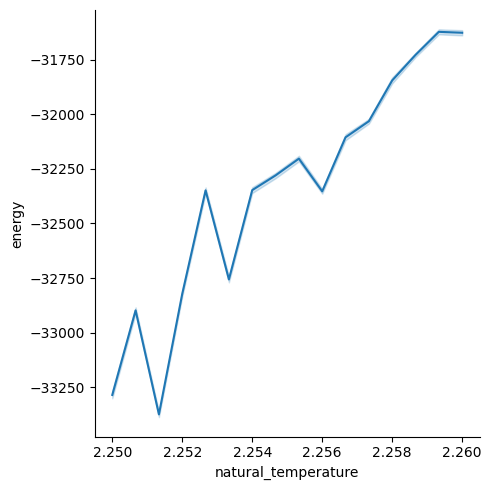

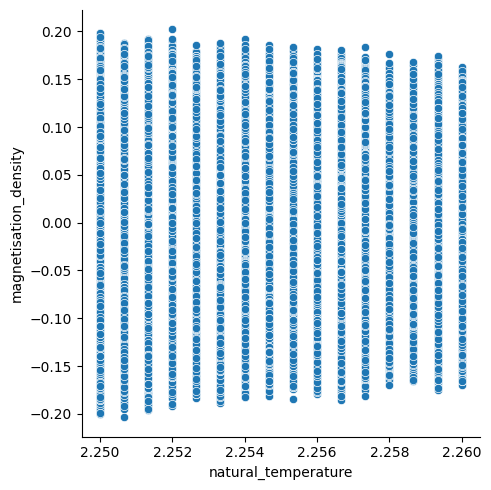

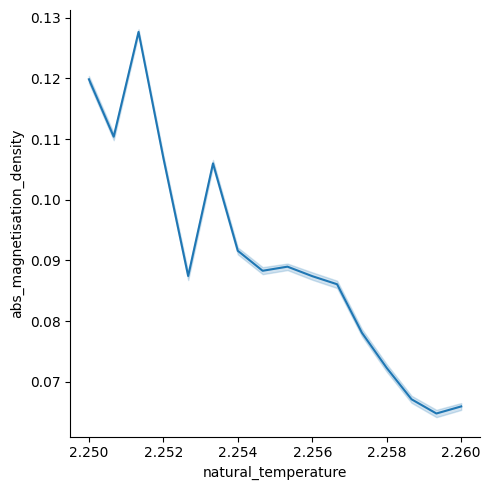

In [23]:
if c.do_measure:
    fig_measure_energy_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="energy",
        kind="line",
    )
    fig_measure_energy_temp.savefig(SAVE_PATH / "fig_measure_energy_temp.png")

    fig_measure_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="magnetisation_density",
        # kind="line",
    )
    fig_measure_mag_dens_temp.savefig(SAVE_PATH / "fig_measure_mag_dens_temp.png")

    fig_measure_abs_mag_dens_temp = sns.relplot(
        data=meas_df,
        x="natural_temperature",
        y="abs_magnetisation_density",
        kind="line",
    )
    fig_measure_abs_mag_dens_temp.savefig(
        SAVE_PATH / "fig_measure_abs_mag_dens_temp.png"
    )

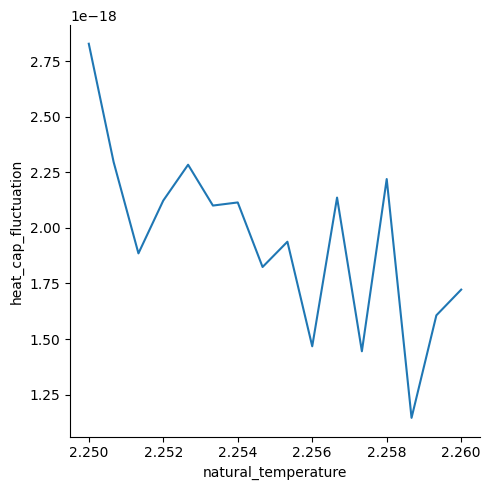

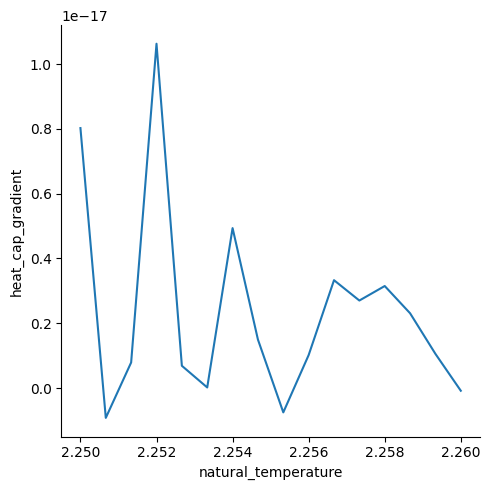

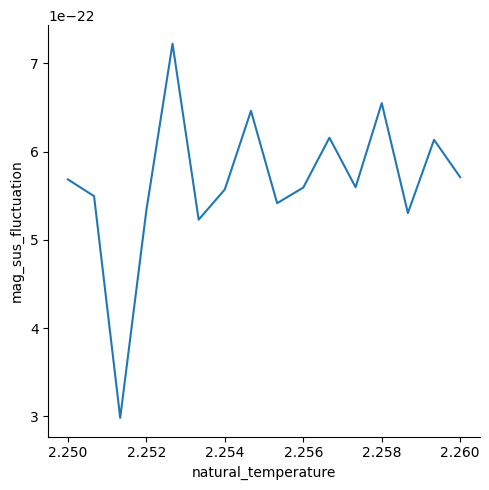

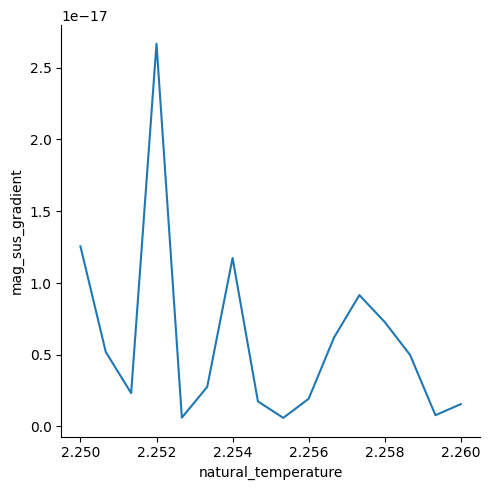

In [24]:
if c.do_measure:
    fig_measure_heat_cap_fluctuation_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_fluctuation",
        kind="line",
    )
    fig_measure_heat_cap_fluctuation_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_fluctuation_temp.png"
    )

    fig_measure_heat_cap_gradient_temp = sns.relplot(
        data=temp_df,
        x="natural_temperature",
        y="heat_cap_gradient",
        kind="line",
    )
    fig_measure_heat_cap_gradient_temp.savefig(
        SAVE_PATH / "fig_measure_heat_cap_gradient_temp.png"
    )

    if not c.interaction_external_field:
        fig_measure_mag_sus_fluctuation_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_fluctuation",
            kind="line",
        )
        fig_measure_mag_sus_fluctuation_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_fluctuation_temp.png"
        )

        fig_measure_mag_sus_gradient_temp = sns.relplot(
            data=temp_df,
            x="natural_temperature",
            y="mag_sus_gradient",
            kind="line",
        )
        fig_measure_mag_sus_gradient_temp.savefig(
            SAVE_PATH / "fig_measure_mag_sus_gradient_temp.png"
        )

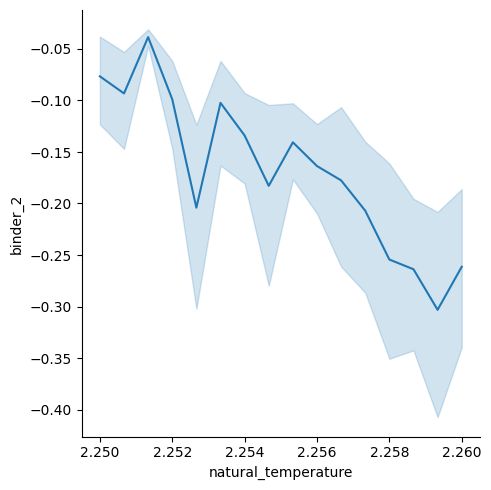

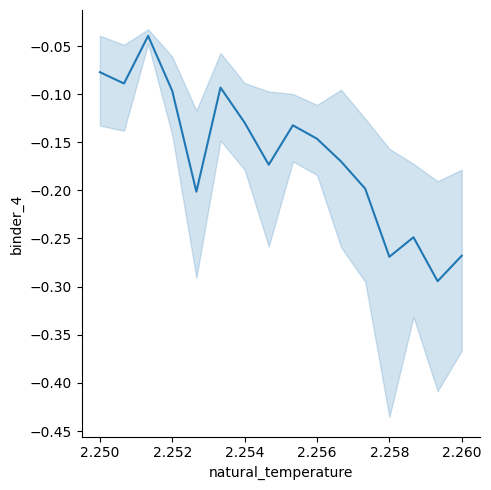

In [25]:
if c.do_measure:
    fig_measure_binder_2 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_2",
        kind="line",
    )
    fig_measure_binder_2.savefig(SAVE_PATH / "fig_measure_binder_2.png")

    fig_measure_binder_4 = sns.relplot(
        data=sample_df,
        x="natural_temperature",
        y="binder_4",
        kind="line",
    )
    fig_measure_binder_4.savefig(SAVE_PATH / "fig_measure_binder_4.png")

In [26]:
with open(SAVE_PATH / "saved_variables.json", "w") as f:
    json.dump(
        to_save, f, indent=4, sort_keys=True, ensure_ascii=False, cls=NumpyEncoder
    )